In [1]:
from subprocess import Popen, PIPE
import getpass
username='EZAGAYNAYA'
REALM='BEE.VIMPELCOM.RU'
password = getpass.getpass(prompt='Enter Your Ldap password:\n')
kinit = 'kinit'
kinit_args = [ kinit, '%s@%s' % (username, REALM) ]
kinit = Popen(kinit_args, stdin=PIPE, stdout=PIPE, stderr=PIPE)
kinit.stdin.write(bytearray(password + "\n", "ascii"))
kinit.stdin.flush()
kinit.wait()

Enter Your Ldap password:
 ········


0

In [2]:
from pyspark import SparkConf  # noqa: E402
from pyspark.sql import DataFrame as SparkDataFrame  # noqa: E402
from pyspark.sql import SparkSession  # noqa: E402
from pyspark.sql import functions as F  # noqa: E402
from pyspark.sql.functions import col, when, min, max, sum, mean, count, substring, countDistinct, last_day, concat_ws 
from pyspark.sql.types import StringType, LongType

SPARK_SETTINGS = [
    ('spark.yarn.queue', 'default'),
        ('spark.sql.sources.partitionOverwriteMode', 'dynamic'),
        ('hive.exec.dynamic.partition', 'true'),
        ('hive.exec.dynamic.partition.mode', 'nonstrict'),
        ('spark.default.parallelism', '400'),
        ('spark.driver.memory', '20G'),
        ('spark.driver.memoryOverhead', '2G'),
        ('spark.driver.cores', 4),
        ('spark.driver.maxResultSize', '150G'),
        ('spark.dynamicAllocation.enabled', 'false'),
        ('spark.dynamicAllocation.maxExecutors', 200),
        ('spark.executor.memory', '20G'),
        ('spark.executor.memoryOverhead', '4G'),
        ('spark.executor.cores', 6),
        ('spark.executor.instances', 10),
        ('spark.hadoop.mapreduce.input.fileinputformat.input.dir.recursive', 'true'),
        ('spark.hive.mapred.supports.subdirectories', 'true'),# драйвер (понадобится для чтения из RDBMS)
        ('spark.kryoserializer.buffer', '1000m'),
        ('spark.kryoserializer.buffer.max', '2000m'),
        ('spark.rpc.message.maxSize', 2000),
        ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'),
        ('spark.sql.execution.arrow.pyspark.enabled', 'true'),
        ('spark.sql.shuffle.partitions', '400'),
        ('spark.driver.extraClassPath', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'), # драйвер (понадобится для чтения из RDBMS)
        ('spark.jars', '/lib/oracle/19.8/client64/lib/ojdbc8.jar'),
        ("spark.sql.hive.convertMetastoreOrc", " false"),
        ('spark.app.name', 'SVFomenkov_testing_pipeline')
]

app_name = 'ZEM_spark_session'

conf = SparkConf().setAppName(app_name).setMaster('yarn').setAll(SPARK_SETTINGS)
spark = SparkSession.builder.config(conf=conf).enableHiveSupport().getOrCreate()
spark.sparkContext.setLogLevel('ERROR')
spark.conf.set("spark.sql.hive.convertMetastoreOrc", " false")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/12 16:06:07 WARN HiveConf: HiveConf of name hive.mapred.supports.subdirectories does not exist
25/05/12 16:06:08 WARN Client: Neither spark.yarn.jars nor spark.yarn.archive is set, falling back to uploading libraries under SPARK_HOME.


In [3]:
from IPython.display import display, HTML
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>"))

/tmp/ipykernel_8328/3383840084.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


#### df_external

In [4]:
# agg_b2b_cvm_client_profile_m_inn_b2bs
# org_kontur_focus_galaxy

# df_external = spark.read.table('b2b_profile.agg_b2b_cvm_client_profile_m_inn_b2bs')

# print(df_external.count()) 

In [ ]:
df_external = df_external.filter(df_external["time_key"] == '2025-02-01')
print(df_external.count())

# df_external.describe().show()

In [249]:
# df_external.dtypes
print('number of features:', len(df_external.columns))
df_external.printSchema()

number of features: 61
root
 |-- client_inn: string (nullable = true)
 |-- contact_email: string (nullable = true)
 |-- url_vkontakte: string (nullable = true)
 |-- url_odnoklassniki: string (nullable = true)
 |-- url_website: string (nullable = true)
 |-- rubric_by2gis: string (nullable = true)
 |-- cnt_points_by2gis: long (nullable = true)
 |-- rev_last_year_bykontur: string (nullable = true)
 |-- contact_phone: string (nullable = true)
 |-- code_okved_main: string (nullable = true)
 |-- name_okved_main: string (nullable = true)
 |-- brand_by2gis: string (nullable = true)
 |-- age: double (nullable = true)
 |-- code_region_reg: string (nullable = true)
 |-- gendir_bykontur: string (nullable = true)
 |-- privacy_form: string (nullable = true)
 |-- website_1: string (nullable = true)
 |-- website_2: string (nullable = true)
 |-- website_3: string (nullable = true)
 |-- in_free_domain: integer (nullable = true)
 |-- fact_address: string (nullable = true)
 |-- cnt_employee: integer (null

In [250]:
df_external_shape = df_external.count()
df_external_shape

7735500

In [251]:
from pyspark.sql.functions import isnan, when, count, col

# df_external.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_external.columns]).show()

import pyspark.sql.functions as F
df_na_1 = df_external.select([F.count(F.when(F.isnan(c) | F.isnull(c), c)).alias(c) for (c,c_type) in df_external.dtypes if c_type not in ('timestamp', 'string', 'date', 'boolean')]).toPandas().T
df_na_1.rename(columns = {0: 'count_na'}, inplace = True)
df_na_1['%_na'] = df_na_1['count_na'] / df_external_shape

df_na_1

,count_na,%_na
cnt_points_by2gis,7604508,0.983066
age,1177237,0.152186
in_free_domain,7724104,0.998527
cnt_employee,5445026,0.703901
stated_capital,5139143,0.664358
net_profit,5230187,0.676128
cnt_last_mon_client_website_visits,6856226,0.886333
cnt_last_mon_client_website2_visits,7697037,0.995028
cnt_last_mon_client_website3_visits,7729114,0.999174
net_profit_latestperiod,5229791,0.676077


In [252]:
df_external.select([ sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_external.columns ]).show()

+----------+-------------+-------------+-----------------+-----------+-------------+-----------------+----------------------+-------------+---------------+---------------+------------+-------+---------------+---------------+------------+---------+---------+---------+--------------+------------+------------+---------+--------------+--------------+----------+-------------------+----------------+----------------+----------------------------------+-----------------------------------+-----------------------------------+----------------------+--------------------------------+-------------------------+---------------------------------------+--------------+-------------+------------------------+------------------------+-------------------------+----------+----------+----------+------------+------------+-------------------+-------------------+------------+---------+------------+-----------+-----------------+----------+-----------------------+----------------+-----------------+------------------

In [253]:
df_null_counts = df_external.select([ sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_external.columns ]).toPandas().T

df_null_counts.rename(columns = {0: 'count_null'}, inplace = True)
df_null_counts['part_null'] = df_null_counts['count_null'] / df_external_shape
df_null_counts

,count_null,part_null
client_inn,0,0.000000
contact_email,7724104,0.998527
url_vkontakte,7467811,0.965395
url_odnoklassniki,7705347,0.996102
url_website,7409242,0.957823
...,...,...
rubric_by2gis_ext,7129436,0.921652
kontur_status_group,7013314,0.906640
rev_last_year_bykontur_latestperiod,5267478,0.680949
cnt_employee_latestperiod,5445026,0.703901


#### df_internal

In [22]:
df_rep_client_info_pub = (spark.read.table('b3p.rep_client_info_pub'))

print('num_rows:', df_rep_client_info_pub.count())
print('num_cols:', len(df_rep_client_info_pub.columns))
df_rep_client_info_pub.show()

num_rows: 10481575
num_cols: 78
+--------------------+---------+--------------------+------+----------+----------+-----------+----------------+-------------+-------------+-------------+-----------------+---------------+-----------------+-------------------+-----------------+--------------------+--------------------+----------+--------------------+-------------+-----------------+-----------------+------------------+-----------------------+----------------+------------------+--------------------+------------------------+---------------------+--------------------+----------+--------------------+------------+----------------+-------------+-----------+-------------+---------------+---------------+-----------+--------------------+---------------+---------------+---------------+----------------------+-----------------+--------------------+--------------+-------------------+--------------------+-------------+--------------+----------------+---------------+--------------------+-----------------

In [23]:
df_rep_client_info_pub.columns

['BAN_OBJID',
 'BAN',
 'BAN_NAME',
 'BAN_AT',
 'BAN_MARKET',
 'BAN_STATUS',
 'BAN_SEGMENT',
 'BAN_CROSS_SCHEME',
 'BAN_SALES',
 'BAN_SERVICE',
 'BAN_INITIATOR',
 'BAN_FINAL_SEGMENT',
 'BAN_FINAL_SALES',
 'BAN_FINAL_SERVICE',
 'BAN_FINAL_INITIATOR',
 'BAN_X_EXTERNAL_ID',
 'CUSTOMER_OBJID',
 'PARENT_BAN_OBJID',
 'PARENT_BAN',
 'PARENT_BAN_NAME',
 'PARENT_BAN_AT',
 'PARENT_BAN_MARKET',
 'PARENT_BAN_STATUS',
 'PARENT_BAN_SEGMENT',
 'PARENT_BAN_CROSS_SCHEME',
 'PARENT_BAN_SALES',
 'PARENT_BAN_SERVICE',
 'PARENT_BAN_INITIATOR',
 'PARENT_BAN_X_EXTERNAL_ID',
 'PARENT_CUSTOMER_OBJID',
 'CLIENT_OBJID',
 'CLIENT_ID',
 'CLIENT_NAME',
 'CLIENT_INN',
 'CLIENT_HQ_MARKET',
 'CLIENT_STATUS',
 'CLIENT_KAM',
 'CLIENT_SM',
 'CLIENT_REF',
 'CLIENT_CATEGORY',
 'CLIENT_TYPE',
 'CLIENT_ORG_FORM',
 'CLIENT_INFO_SRC',
 'CLIENT_DOC_TYPE',
 'CLIENT_X_SERIES',
 'CLIENT_DOCUMENT_NUMBER',
 'CLIENT_TRADE_MARK',
 'CLIENT_ALT_NAME',
 'CLIENT_SEGMENT',
 'CLIENT_CROSS_SCHEME',
 'CLIENT_ZONE',
 'CLIENT_SALES',
 'CLIENT_SE

In [24]:
df_external = df_external.select([col(c).alias(c.upper()) for c in df_external.columns])
df_external.show(10)

+------------+-------------+--------------------+-----------------+-----------+-------------+-----------------+----------------------+--------------------+---------------+--------------------+------------+----+---------------+--------------------+--------------------+---------+---------+---------+--------------+--------------------+------------+---------+--------------+--------------------+--------------------+-------------------+----------------+--------------------+----------------------------------+-----------------------------------+-----------------------------------+----------------------+--------------------------------+-------------------------+---------------------------------------+--------------+-------------+------------------------+------------------------+-------------------------+----------+--------------------+----------+------------+------------+-------------------+--------------------+------------------+---------+------------+--------------------+--------------------+

In [25]:
common_columns = list(set(df_rep_client_info_pub.columns) & set(df_external.columns))
common_columns

['CLIENT_INN']

#### df_external 2

In [5]:
# agg_b2b_cvm_client_profile_m_inn_b2bs
# org_kontur_focus_galaxy

df_external_2 = spark.read.table('b2b_profile.org_kontur_focus_galaxy')

print('num_rows:', df_external_2.count())  # 
print('num_cols:', len(df_external_2.columns))  # 
df_external_2.show(10)

num_rows: 6280540
num_cols: 47
+------------+---------------+--------------------+---------+--------------------+--------------------+--------------------+-----------------+--------------------+-----------+---------------+-----------+-----------+-----------+---------+----------+------------+-----------+-----------+----+-------+-----+----------+-----------+----------------+----+--------------------+--------------------+----------+--------------------+----------------+--------------------+------------------+--------------------+-------------------+-------------+--------+-----------+------------+--------------+-------------------+-------------------+-------+------------+----------+---------------+----------+
|         inn|           ogrn|          legal_name|      kpp|    legal_name_short|     legal_name_full|                 opf|registration_date|       legal_address|region_type|    region_name|region_code|     status|bankrupting|dissolved|dissolving|reorganizing|status_date|      okato|

In [ ]:
df_null_counts = df_external_2.select([ sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df_external_2.columns ]).toPandas().T
df_external_shape_2 = df_external_2.count()

df_null_counts.rename(columns = {0: 'count_null'}, inplace = True)
df_null_counts['part_null'] = df_null_counts['count_null'] / df_external_shape
df_null_counts

In [ ]:
df_external_2 = df_external_2.select([col(c).alias(c.upper()) for c in df_external_2.columns])
df_external_2.show(3)

In [ ]:
df_external_2 = df_external_2.withColumnRenamed('INN', 'CLIENT_INN')

In [ ]:
common_columns = list(set(df_rep_client_info_pub.columns) & set(df_external_2.columns))
common_columns

In [ ]:
# df_external_2.select('TIME_KEY').distinct().show()
# +----------+
# |  TIME_KEY|
# +----------+
# |2025-04-02|
# +----------+

In [ ]:
# df_external_2_pd = df_external_2.toPandas()

# print(df_external_2_pd.shape)
# df_external_2_pd.head(3)

#### Pandas

In [4]:
import pandas as pd
import numpy as np
import scipy as sp

import pickle
# import shap

import statsmodels
import statsmodels.api as sm

import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection, datasets, linear_model, metrics

import seaborn as sns

import datetime as dt
from datetime import datetime
from datetime import date
import math

# TF-IDF:
import sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sum', 'max', 'datetime', 'mean', 'min']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [5]:
# df_external_2 = spark.read.table('b2b_profile.org_kontur_focus_galaxy')

# df_external_2_pd.to_pickle('df_external_2_pd.pkl')
df = pd.read_pickle('df_external_2_pd.pkl')

print(df.shape)
df.head(2)

# (6 293 630, 47)

(6293630, 47)


,CLIENT_INN,OGRN,LEGAL_NAME,KPP,LEGAL_NAME_SHORT,LEGAL_NAME_FULL,OPF,REGISTRATION_DATE,LEGAL_ADDRESS,REGION_TYPE,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
0,0100008758,1240100001580,"ООО ""Омнитех Солюшнс""",010001001,"ООО ""ОМНИТЕХ СОЛЮШНС""","ОБЩЕСТВО С ОГРАНИЧЕННОЙ ОТВЕТСТВЕННОСТЬЮ ""ОМНИ...",Общества с ограниченной ответственностью,2024-06-06,"385141, Республика Адыгея (Адыгея), м.р-н Тахт...",республика,...,2024-07-10,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02
1,0100009649,1240100002482,Региональная Физкультурно-Спортивная Обществен...,010001001,"РФС ОО ""ФЛБ"" РА",РЕГИОНАЛЬНАЯ ФИЗКУЛЬТУРНО-СПОРТИВНАЯ ОБЩЕСТВЕН...,Общественные организации,2024-08-30,"385019, Республика Адыгея (Адыгея), г.о. Город...",республика,...,None,None,NaN,None,NaN,NaN,NaN,NaN,NaN,2025-04-02


In [6]:
# df.info()
df_null_count = pd.DataFrame(df.isnull().sum())
df_null_count.rename(columns = {0: 'count_null'}, inplace = True)
df_null_count['part_null'] = df_null_count['count_null'] / df.shape[0]
# df_null_count

In [7]:
# df.drop('')
col_to_drop = list(df_null_count[df_null_count['part_null'] == 1].index)
print(len(col_to_drop))
col_to_drop

1


['DISSOLVED']

In [8]:
print(df.shape)
df.drop(col_to_drop, axis = 1, inplace = True)
print(df.shape)

(6293630, 47)
(6293630, 46)


In [9]:
col_to_drop_2 = list(df_null_count[df_null_count['part_null'] > 0.99].index)
print(len(col_to_drop_2))
col_to_drop_2

5


['BANKRUPTING',
 'DISSOLVED',
 'REORGANIZING',
 'DISSOLUTION_DATE',
 'MSP_OUT_DATE']

In [10]:
print(df.shape) 
print('NA REVENUE:', df[df['REVENUE'].isna() == True].shape) 
print('Part NA REVENUE:', df[df['REVENUE'].isna() == True].shape[0] / df.shape[0]) 

print('> 0 REVENUE:', df[df['REVENUE'] > 0].shape) 
print('0 REVENUE:', df[df['REVENUE'] == 0].shape) 
print('< 0 REVENUE:', df[df['REVENUE'] < 0].shape) 

(6293630, 46)
NA REVENUE: (3932475, 46)
Part NA REVENUE: 0.6248341577118451
> 0 REVENUE: (1732001, 46)
0 REVENUE: (628743, 46)
< 0 REVENUE: (411, 46)


In [11]:
3932475 * 0.002

7864.95

In [12]:
df['REVENUE_YEAR'].value_counts()

2024.0    1009646
2023.0     712782
2018.0     238087
2022.0     114530
2021.0      95398
2020.0      67080
2019.0      52640
2017.0      31209
2016.0      17884
2015.0      11721
2014.0       5258
2013.0       4308
2012.0       1064
Name: REVENUE_YEAR, dtype: int64

In [13]:
df[df['REVENUE_YEAR'] == 2024]['REVENUE'].isnull().sum()

0

In [14]:
df.shape

(6293630, 46)

In [15]:
# df.iloc[:, 0:20].head(1).T

In [16]:
df['REVENUE_YEAR'].value_counts()

2024.0    1009646
2023.0     712782
2018.0     238087
2022.0     114530
2021.0      95398
2020.0      67080
2019.0      52640
2017.0      31209
2016.0      17884
2015.0      11721
2014.0       5258
2013.0       4308
2012.0       1064
Name: REVENUE_YEAR, dtype: int64

#### Data processing

In [17]:
df = df[df['REVENUE_YEAR'] == 2024]

# df = df[df['REVENUE'].isna() == True]
# df = df.sample(n = 1009646)

print(df.shape)
df.head(2)

# (1 009 646, 46)

(1009646, 46)


,CLIENT_INN,OGRN,LEGAL_NAME,KPP,LEGAL_NAME_SHORT,LEGAL_NAME_FULL,OPF,REGISTRATION_DATE,LEGAL_ADDRESS,REGION_TYPE,...,MSP_IN_DATE,MSP_OUT_DATE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY
41,0105034222,1020100703457,"ООО ""Персональные системы""",010501001,"ООО ""Персональные системы""","Общество с ограниченной ответственностью ""Перс...",Общества с ограниченной ответственностью,2001-04-18,"385000, Республика Адыгея, г.о. город Майкоп, ...",республика,...,2016-08-01,None,4.0,2023-12-31,2023.0,3904000.0,2024.0,1089000.0,2024.0,2025-04-02
42,0105039171,1030100530030,"ООО ""Гиппократ""",010501001,"ООО ""Гиппократ""","Общество с ограниченной ответственностью ""Гипп...",Общества с ограниченной ответственностью,2003-03-19,"385008, Республика Адыгея (Адыгея), г. Майкоп,...",республика,...,2016-08-01,None,15.0,2023-12-31,2023.0,77425000.0,2024.0,33158000.0,2024.0,2025-04-02


In [18]:
# df['OPF'].value_counts()

In [19]:
df_OPF = pd.DataFrame(df['OPF'].value_counts())
# df_OPF[df_OPF['OPF'] > 10]

In [20]:
l_ind = list(df_OPF.index)
# l_ind

In [21]:
[ i for i in l_ind if 'акцио' in i ]

['Непубличные акционерные общества', 'Публичные акционерные общества']

In [22]:
# ООО: 'Общества с ограниченной ответственностью'

# ОАО: 'Открытые акционерные общества'
# ПАО: 'Публичные акционерные общества'
# АО, ЗАО: 'Непубличные акционерные общества'

In [23]:
df = df[df['OPF'].isin(['Общества с ограниченной ответственностью',
                        'Открытые акционерные общества',
                        'Публичные акционерные общества',
                        'Непубличные акционерные общества'])]
print(df.shape)
df['OPF'].value_counts()

(952828, 46)


Общества с ограниченной ответственностью    935100
Непубличные акционерные общества             16007
Публичные акционерные общества                1721
Name: OPF, dtype: int64

In [213]:
print((df.shape))
df['CLIENT_INN'].apply(lambda x: len(x)).value_counts()

(952828, 49)


10    952828
Name: CLIENT_INN, dtype: int64

##### Dates

In [24]:
# from datetime import datetime

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [25]:
from datetime import datetime
datetime.now()

datetime.datetime(2025, 5, 12, 16, 11, 45, 605349)

In [26]:
df['MSP_IN_DATE'] = df['MSP_IN_DATE'].astype('datetime64')
df['MSP_OUT_DATE'] = df['MSP_OUT_DATE'].astype('datetime64')
df['STATUS_DATE'] = df['STATUS_DATE'].astype('datetime64')
df['COUNT_EMPLOYEE_DATE'] = df['COUNT_EMPLOYEE_DATE'].astype('datetime64')

In [27]:
df['MSP_IN_DATE_dist'] = df['MSP_IN_DATE'].apply(lambda x: diff_month(datetime.now(), x))
df['MSP_OUT_DATE_dist'] = df['MSP_OUT_DATE'].apply(lambda x: diff_month(datetime.now(), x))
df['STATUS_DATE_dist'] = df['STATUS_DATE'].apply(lambda x: diff_month(datetime.now(), x))

df[['MSP_IN_DATE', 'MSP_IN_DATE_dist']].head(5)

,MSP_IN_DATE,MSP_IN_DATE_dist
41,2016-08-01,105.0
42,2016-08-01,105.0
45,2016-08-01,105.0
46,2016-08-01,105.0
47,2016-08-01,105.0


#### Objects

In [28]:
print(df.select_dtypes(include = ['object']).shape)
df.select_dtypes(include = ['object']).head(2)

# (6293629, 34)

(952828, 34)


,CLIENT_INN,OGRN,LEGAL_NAME,KPP,LEGAL_NAME_SHORT,LEGAL_NAME_FULL,OPF,REGISTRATION_DATE,LEGAL_ADDRESS,REGION_TYPE,...,PRIVACY_FORM,OKVED_CODE,OKVED_TEXT,OKVED_CLASS_CODE,OKVED_CLASS_NAME,OKVED_CHAPTER_CODE,OKVED_CHAPTER_NAME,INDUSTRY_GROUP,MSP_TYPE,TIME_KEY
41,0105034222,1020100703457,"ООО ""Персональные системы""",010501001,"ООО ""Персональные системы""","Общество с ограниченной ответственностью ""Перс...",Общества с ограниченной ответственностью,2001-04-18,"385000, Республика Адыгея, г.о. город Майкоп, ...",республика,...,Частная собственность,62.01,Разработка компьютерного программного обеспечения,62,Разработка компьютерного программного обеспече...,J,ДЕЯТЕЛЬНОСТЬ В ОБЛАСТИ ИНФОРМАЦИИ И СВЯЗИ,"Компьютеры, ПО и деятельность в сфере ИТ",micro,2025-04-02
42,0105039171,1030100530030,"ООО ""Гиппократ""",010501001,"ООО ""Гиппократ""","Общество с ограниченной ответственностью ""Гипп...",Общества с ограниченной ответственностью,2003-03-19,"385008, Республика Адыгея (Адыгея), г. Майкоп,...",республика,...,Частная собственность,86.21,Общая врачебная практика,86,Деятельность в области здравоохранения,Q,ДЕЯТЕЛЬНОСТЬ В ОБЛАСТИ ЗДРАВООХРАНЕНИЯ И СОЦИА...,Медицинские учреждения,micro,2025-04-02


In [29]:
# X = df[(df['NET_PROFIT'] > 0) | (df['NET_PROFIT'].isna() == True)].drop(['CLIENT_INN', 'OGRN', 'LEGAL_NAME', 
# X = df[df['REVENUE_YEAR'] == 2024.0].drop(['CLIENT_INN', 'OGRN', 'LEGAL_NAME', 

# X = df.drop(['CLIENT_INN', 'OGRN', 'LEGAL_NAME', 
X = df.drop(['LEGAL_NAME_SHORT', 'LEGAL_NAME_FULL', 
             'REGISTRATION_DATE','LEGAL_ADDRESS', 'HEADS',
             'OKVED_CODE', 'OKVED_TEXT', 'REGION_NAME',
             'DISSOLVING', 'DISSOLUTION_DATE', 
             'COUNT_EMPLOYEE_DATE', 
             'OKVED_CHAPTER_NAME', 'OKVED_CLASS_NAME',
             'STATUS_DATE', 'MSP_IN_DATE', 'MSP_OUT_DATE',
             'KPP', 'OKATO', 'OKFS', 'OKOGU', 'OKOPF', 'OKPO', 'OKTMO',
             'TIME_KEY'], axis = 1).reset_index()

X.drop('index', axis = 1, inplace = True)

print(X.index)
print(X.shape)
X.head(2)

RangeIndex(start=0, stop=952828, step=1)
(952828, 25)


,CLIENT_INN,OGRN,LEGAL_NAME,OPF,REGION_TYPE,REGION_CODE,STATUS,BANKRUPTING,REORGANIZING,AGE,...,MSP_TYPE,COUNT_EMPLOYEE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,STATUS_DATE_dist
0,0105034222,1020100703457,"ООО ""Персональные системы""",Общества с ограниченной ответственностью,республика,01,Действующее,None,None,24.0,...,micro,4.0,2023.0,3904000.0,2024.0,1089000.0,2024.0,105.0,NaN,NaN
1,0105039171,1030100530030,"ООО ""Гиппократ""",Общества с ограниченной ответственностью,республика,01,Действующее,None,None,22.1,...,micro,15.0,2023.0,77425000.0,2024.0,33158000.0,2024.0,105.0,NaN,NaN


In [30]:
print(X.shape)
print(X.select_dtypes(include = ['float64']).shape)
print(X.select_dtypes(include = ['datetime64']).shape)
print(X.select_dtypes(include = ['object']).shape)
X.select_dtypes(include = ['object']).head(2)

(952828, 25)
(952828, 11)
(952828, 0)
(952828, 14)


,CLIENT_INN,OGRN,LEGAL_NAME,OPF,REGION_TYPE,REGION_CODE,STATUS,BANKRUPTING,REORGANIZING,PRIVACY_FORM,OKVED_CLASS_CODE,OKVED_CHAPTER_CODE,INDUSTRY_GROUP,MSP_TYPE
0,0105034222,1020100703457,"ООО ""Персональные системы""",Общества с ограниченной ответственностью,республика,01,Действующее,None,None,Частная собственность,62,J,"Компьютеры, ПО и деятельность в сфере ИТ",micro
1,0105039171,1030100530030,"ООО ""Гиппократ""",Общества с ограниченной ответственностью,республика,01,Действующее,None,None,Частная собственность,86,Q,Медицинские учреждения,micro


In [31]:
# X.info()

In [32]:
df['MSP_TYPE'].value_counts()

micro     825613
small      95134
middle      7917
Name: MSP_TYPE, dtype: int64

In [33]:
# dummies.dtypes
# uint8

In [34]:
categ_columns = ['REGION_TYPE', 'BANKRUPTING', 'REORGANIZING', 'MSP_TYPE', 'OKVED_CHAPTER_CODE']

for column in categ_columns: 
    
    dummies = pd.get_dummies(X[column], prefix = column)
    X[dummies.columns] = dummies
    X.drop([column], inplace = True, axis = 1)

In [35]:
print(X.shape)
X.head(2)

(952828, 53)


,CLIENT_INN,OGRN,LEGAL_NAME,OPF,REGION_CODE,STATUS,AGE,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP,...,OKVED_CHAPTER_CODE_L,OKVED_CHAPTER_CODE_M,OKVED_CHAPTER_CODE_N,OKVED_CHAPTER_CODE_O,OKVED_CHAPTER_CODE_P,OKVED_CHAPTER_CODE_Q,OKVED_CHAPTER_CODE_R,OKVED_CHAPTER_CODE_S,OKVED_CHAPTER_CODE_T,OKVED_CHAPTER_CODE_U
0,0105034222,1020100703457,"ООО ""Персональные системы""",Общества с ограниченной ответственностью,01,Действующее,24.0,Частная собственность,62,"Компьютеры, ПО и деятельность в сфере ИТ",...,0,0,0,0,0,0,0,0,0,0
1,0105039171,1030100530030,"ООО ""Гиппократ""",Общества с ограниченной ответственностью,01,Действующее,22.1,Частная собственность,86,Медицинские учреждения,...,0,0,0,0,0,1,0,0,0,0


In [36]:
print(X.select_dtypes(include = ['object']).shape)
X.select_dtypes(include = ['object']).head(2)

# (5256458, 6)

(952828, 9)


,CLIENT_INN,OGRN,LEGAL_NAME,OPF,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP
0,0105034222,1020100703457,"ООО ""Персональные системы""",Общества с ограниченной ответственностью,01,Действующее,Частная собственность,62,"Компьютеры, ПО и деятельность в сфере ИТ"
1,0105039171,1030100530030,"ООО ""Гиппократ""",Общества с ограниченной ответственностью,01,Действующее,Частная собственность,86,Медицинские учреждения


In [37]:
X.select_dtypes(include = ['object']).columns

Index(['CLIENT_INN', 'OGRN', 'LEGAL_NAME', 'OPF', 'REGION_CODE', 'STATUS',
       'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP'],
      dtype='object')

#### TF-IDF Vectorization

In [38]:
# import sklearn.feature_extraction.text
# from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
print(df[df['KPP'] == '720301001'].shape)
df[df['KPP'] == '720301001'].head(2)

(10387, 49)


,CLIENT_INN,OGRN,LEGAL_NAME,KPP,LEGAL_NAME_SHORT,LEGAL_NAME_FULL,OPF,REGISTRATION_DATE,LEGAL_ADDRESS,REGION_TYPE,...,COUNT_EMPLOYEE_DATE,COUNT_EMPLOYEE_YEAR,REVENUE,REVENUE_YEAR,NET_PROFIT,NET_PROFIT_YEAR,TIME_KEY,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,STATUS_DATE_dist
3626,1832007271,1021801435732,"ООО ""Фармаимпекс""",720301001,"ООО ""Фармаимпекс""","Общество с ограниченной ответственностью ""Фарм...",Общества с ограниченной ответственностью,1994-03-04,"625031, Тюменская область, г.о. город Тюмень, ...",область,...,NaT,NaN,2.032749e+10,2024.0,29494000.0,2024.0,2025-04-02,NaN,NaN,NaN
14899,5202010473,1065243033240,"ООО ""Частное охранное предприятие ""КАСКАД""",720301001,"ООО ""ЧОП ""КАСКАД""","Общество с ограниченной ответственностью ""Част...",Общества с ограниченной ответственностью,2006-10-26,"625048, Тюменская область, г.о. город Тюмень, ...",область,...,2023-12-31,2023.0,3.037700e+07,2024.0,2278000.0,2024.0,2025-04-02,105.0,NaN,NaN


In [40]:
feature = 'KPP'
texts = df[feature].fillna('-1')

# Initialize TF-IDF model:
vectorizer = TfidfVectorizer(max_features = 5)

# Fit and transform:
tfidf_matrix = vectorizer.fit_transform(texts)

# Convert to DataFrame:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())
tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]
tfidf_df

,KPP_720301001,KPP_774301001,KPP_780201001,KPP_781001001,KPP_781401001
0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
952823,0.0,0.0,0.0,0.0,0.0
952824,0.0,0.0,0.0,0.0,0.0
952825,0.0,0.0,0.0,0.0,0.0
952826,0.0,0.0,0.0,0.0,0.0


In [41]:
# tfidf_df['720301001'].unique()

##### TF_IDF for object columns

In [42]:
# X.info()

In [43]:
print(X.shape)
print(X.select_dtypes(include = ['float64']).shape)
print(X.select_dtypes(include = ['uint8']).shape)
print(X.select_dtypes(include = ['object']).shape)
X.select_dtypes(include = ['object']).head(2)

(952828, 53)
(952828, 11)
(952828, 33)
(952828, 9)


,CLIENT_INN,OGRN,LEGAL_NAME,OPF,REGION_CODE,STATUS,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP
0,0105034222,1020100703457,"ООО ""Персональные системы""",Общества с ограниченной ответственностью,01,Действующее,Частная собственность,62,"Компьютеры, ПО и деятельность в сфере ИТ"
1,0105039171,1030100530030,"ООО ""Гиппократ""",Общества с ограниченной ответственностью,01,Действующее,Частная собственность,86,Медицинские учреждения


In [44]:
# X['OKFS'].value_counts()

In [45]:
X.select_dtypes(include = ['object']).columns

Index(['CLIENT_INN', 'OGRN', 'LEGAL_NAME', 'OPF', 'REGION_CODE', 'STATUS',
       'PRIVACY_FORM', 'OKVED_CLASS_CODE', 'INDUSTRY_GROUP'],
      dtype='object')

In [46]:
X.shape

(952828, 53)

In [47]:
X.index

RangeIndex(start=0, stop=952828, step=1)

In [48]:
X_not_target = X[(X['REVENUE'].isnull() == False) & 
                 (X['COUNT_EMPLOYEE'].isnull() == False)].drop(['CLIENT_INN', 'OGRN', 'LEGAL_NAME',
                                                                'REVENUE', 'REVENUE_YEAR',
                                                       'NET_PROFIT', 'NET_PROFIT_YEAR',
                                                       'COUNT_EMPLOYEE', 'COUNT_EMPLOYEE_YEAR'], axis = 1)

y = X[(X['REVENUE'].isnull() == False) & 
      (X['COUNT_EMPLOYEE'].isnull() == False)][['REVENUE', 'COUNT_EMPLOYEE']].apply(lambda x: 1 if (x['REVENUE'] >= 1500000000) |
                                                                           (x['COUNT_EMPLOYEE'] >= 100) else 0, axis = 1)

print(X_not_target.shape)
y.value_counts()

(918624, 44)


0    902744
1     15880
dtype: int64

In [49]:
15880 / 918624

0.017286724492284113

In [50]:
# X_not_target = X_not_target[features_corr_BE_L1]
print(X_not_target.shape)

# X_train, X_test_last, y_train, y_test_last = train_test_split(X_not_target, y, test_size = 0.20, random_state = 42, stratify = y)

X_train, X_test_last, y_train, y_test_last = train_test_split(X_not_target, y, test_size = 0.10, random_state = 42, stratify = y)

print(X_train.shape, X_test_last.shape)
print(y_train.mean(), y_test_last.mean())

(918624, 44)
(826761, 44) (91863, 44)
0.017286737037668684 0.01728661158464235


In [51]:
X_y_test_last = pd.concat([X_test_last, y_test_last], axis = 1)
X_y_test_last.rename(columns = {0: 'REVENUE'}, inplace = True)
X_y_test_last.reset_index(drop = True, inplace = True)
print(X_y_test_last.shape)
X_y_test_last.head(2)

(91863, 45)


,OPF,REGION_CODE,STATUS,AGE,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP,STATEDCAPITAL,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,...,OKVED_CHAPTER_CODE_M,OKVED_CHAPTER_CODE_N,OKVED_CHAPTER_CODE_O,OKVED_CHAPTER_CODE_P,OKVED_CHAPTER_CODE_Q,OKVED_CHAPTER_CODE_R,OKVED_CHAPTER_CODE_S,OKVED_CHAPTER_CODE_T,OKVED_CHAPTER_CODE_U,REVENUE
0,Общества с ограниченной ответственностью,41,Действующее,9.4,Частная собственность,47,Ритейл,20000.0,105.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,Общества с ограниченной ответственностью,18,Действующее,5.2,Частная собственность,25,Производство,10000.0,63.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [52]:
X = pd.concat([X_train, y_train], axis = 1)
X.rename(columns = {0: 'REVENUE'}, inplace = True)
X.reset_index(drop = True, inplace = True)
print(X.shape)
X.head(2)

(826761, 45)


,OPF,REGION_CODE,STATUS,AGE,PRIVACY_FORM,OKVED_CLASS_CODE,INDUSTRY_GROUP,STATEDCAPITAL,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,...,OKVED_CHAPTER_CODE_M,OKVED_CHAPTER_CODE_N,OKVED_CHAPTER_CODE_O,OKVED_CHAPTER_CODE_P,OKVED_CHAPTER_CODE_Q,OKVED_CHAPTER_CODE_R,OKVED_CHAPTER_CODE_S,OKVED_CHAPTER_CODE_T,OKVED_CHAPTER_CODE_U,REVENUE
0,Общества с ограниченной ответственностью,34,Действующее,22.6,Частная собственность,1,Агро,8466974.0,105.0,NaN,...,0,0,0,0,0,0,0,0,0,1
1,Общества с ограниченной ответственностью,66,Действующее,9.9,Частная собственность,47,Ритейл,10000.0,93.0,NaN,...,0,0,0,0,0,0,0,0,0,0


In [53]:
print('X.shape:', X.shape)
all_features = list(X.select_dtypes(include = ['object']).columns)

# all_features.remove('CLIENT_INN')
all_features = [i for i in all_features if i not in ['CLIENT_INN', 'OGRN', 'LEGAL_NAME']]

all_features

X.shape: (826761, 45)


['OPF',
 'REGION_CODE',
 'STATUS',
 'PRIVACY_FORM',
 'OKVED_CLASS_CODE',
 'INDUSTRY_GROUP']

In [54]:
X.shape

(826761, 45)

In [55]:
len(all_features)

6

In [56]:
for i in range(len(all_features)):
# for i in range(3):
    
    feature = all_features[i]
    texts = X[feature].fillna('-1')
    
    # Initialize TF-IDF model:
    vectorizer = TfidfVectorizer(max_features = 5)
    
    # Fit and transform:
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Convert to DataFrame:
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    X.drop(feature, axis = 1, inplace = True)
    tfidf_df.reset_index(inplace = True, drop = True)
    # print(X.shape)
    X = pd.concat([X, tfidf_df], axis = 1)
    # print(X.shape)

print(X.shape)
X.head(3)

(826761, 69)


,AGE,STATEDCAPITAL,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,STATUS_DATE_dist,REGION_TYPE_автономная область,REGION_TYPE_автономный округ,REGION_TYPE_город,REGION_TYPE_край,REGION_TYPE_область,...,OKVED_CLASS_CODE_41,OKVED_CLASS_CODE_43,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_строительство,INDUSTRY_GROUP_торговля
0,22.6,8466974.0,105.0,NaN,NaN,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,9.9,10000.0,93.0,NaN,NaN,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000
2,23.3,NaN,105.0,NaN,NaN,0,0,1,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107


In [57]:
# tfidf_df

In [58]:
print(X.shape)

(826761, 69)


In [59]:
vectorizer.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [170]:
# ****************** save model transformer 12.05: ******************

# with open('TF_IDF_vectorizer_v2.pkl', 'wb') as fid:
#         pickle.dump(vectorizer, fid)

# # ********************* read transformer: ********************
# with open('TF_IDF_vectorizer_v2.pkl', 'rb') as fid:
#     vectorizer = pickle.load(fid)

# vectorizer.get_params()

In [61]:
tfidf_matrix.shape

(826761, 5)

In [62]:
tfidf_df.shape

(826761, 5)

In [63]:
# X.info()

In [64]:
X['REVENUE'].isna().sum()

0

In [65]:
print(X.shape)
print(X[X['REVENUE'] >= 1500000000].shape)
print(X[X['REVENUE'] >= 1500000000].shape[0] / X.shape[0])

(826761, 69)
(0, 69)
0.0


In [66]:
9940 / 952828

0.01043210317077164

In [67]:
X_null = pd.DataFrame(X.isnull().sum())
X_null.rename(columns = {0: 'count_nulls'}, inplace = True)
X_null['part_null'] = X_null['count_nulls'] / X.shape[0]
X_null.sort_values(by = 'part_null', ascending = False, inplace = True)
X_null

,count_nulls,part_null
MSP_OUT_DATE_dist,826742,0.999977
STATUS_DATE_dist,807374,0.976551
MSP_IN_DATE_dist,20471,0.024760
STATEDCAPITAL,16884,0.020422
AGE,0,0.000000
...,...,...
OKVED_CHAPTER_CODE_N,0,0.000000
OKVED_CHAPTER_CODE_O,0,0.000000
OKVED_CHAPTER_CODE_P,0,0.000000
OKVED_CHAPTER_CODE_Q,0,0.000000


In [68]:
# X.drop(['MSP_OUT_DATE_dist', 'STATUS_DATE_dist'], axis = 1, inplace = True)
# X.shape

#### X y

In [169]:
# 12.05
# X.to_pickle('X_LA_2024_v2.pkl')
# X_y_test_last.to_pickle('X_y_test_last_LA_2024_v2.pkl')

# X = pd.read_pickle('X_LA_2024_v2.pkl')
# X_y_test_last = pd.read_pickle('X_y_test_last_LA_2024_v2.pkl')

print(X_y_test_last.shape)
print(X.shape)
X.head(2)

# (91863, 81)
# (826761, 69)

(91863, 81)
(826761, 69)


,AGE,STATEDCAPITAL,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,STATUS_DATE_dist,REGION_TYPE_автономная область,REGION_TYPE_автономный округ,REGION_TYPE_город,REGION_TYPE_край,REGION_TYPE_область,...,OKVED_CLASS_CODE_41,OKVED_CLASS_CODE_43,OKVED_CLASS_CODE_46,OKVED_CLASS_CODE_47,OKVED_CLASS_CODE_68,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_строительство,INDUSTRY_GROUP_торговля
0,22.6,8466974.0,105.0,NaN,NaN,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9.9,10000.0,93.0,NaN,NaN,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
X['REVENUE'].value_counts()

0    812469
1     14292
Name: REVENUE, dtype: int64

In [71]:
12704 / 734899

0.017286729196801194

In [72]:
# X['REVENUE'].plot()

In [73]:
X['REVENUE'].max()

1

#### X_not_target    y

In [74]:
# X_not_target = X[(X['REVENUE'].isnull() == False) & 
#                  (X['COUNT_EMPLOYEE'].isnull() == False)].drop(['CLIENT_INN', 'OGRN', 'LEGAL_NAME',
#                                                                 'REVENUE', 'REVENUE_YEAR',
#                                                        'NET_PROFIT', 'NET_PROFIT_YEAR',
#                                                        'COUNT_EMPLOYEE', 'COUNT_EMPLOYEE_YEAR'], axis = 1)

# y = X[(X['REVENUE'].isnull() == False) & 
#       (X['COUNT_EMPLOYEE'].isnull() == False)][['REVENUE', 'COUNT_EMPLOYEE']].apply(lambda x: 1 if (x['REVENUE'] >= 1500000000) |
#                                                                            (x['COUNT_EMPLOYEE'] >= 100) else 0, axis = 1)

# print(X_not_target.shape)
# y.value_counts()

X_not_target = X.drop('REVENUE', axis = 1)
y = X['REVENUE']

print(X_not_target.shape)
y.value_counts()

(826761, 68)


0    812469
1     14292
Name: REVENUE, dtype: int64

In [75]:
# 15880 / 918624
12704 / 734899

0.017286729196801194

In [76]:
# X['REVENUE_YEAR'].unique()

In [77]:
X_not_target.columns

Index(['AGE', 'STATEDCAPITAL', 'MSP_IN_DATE_dist', 'MSP_OUT_DATE_dist',
       'STATUS_DATE_dist', 'REGION_TYPE_автономная область',
       'REGION_TYPE_автономный округ', 'REGION_TYPE_город', 'REGION_TYPE_край',
       'REGION_TYPE_область', 'REGION_TYPE_республика', 'REGION_TYPE_чувашия',
       'BANKRUPTING_True', 'REORGANIZING_True', 'MSP_TYPE_micro',
       'MSP_TYPE_middle', 'MSP_TYPE_small', 'OKVED_CHAPTER_CODE_A',
       'OKVED_CHAPTER_CODE_B', 'OKVED_CHAPTER_CODE_C', 'OKVED_CHAPTER_CODE_D',
       'OKVED_CHAPTER_CODE_E', 'OKVED_CHAPTER_CODE_F', 'OKVED_CHAPTER_CODE_G',
       'OKVED_CHAPTER_CODE_H', 'OKVED_CHAPTER_CODE_I', 'OKVED_CHAPTER_CODE_J',
       'OKVED_CHAPTER_CODE_K', 'OKVED_CHAPTER_CODE_L', 'OKVED_CHAPTER_CODE_M',
       'OKVED_CHAPTER_CODE_N', 'OKVED_CHAPTER_CODE_O', 'OKVED_CHAPTER_CODE_P',
       'OKVED_CHAPTER_CODE_Q', 'OKVED_CHAPTER_CODE_R', 'OKVED_CHAPTER_CODE_S',
       'OKVED_CHAPTER_CODE_T', 'OKVED_CHAPTER_CODE_U', 'OPF_акционерные',
       'OPF_непубличные', 

In [78]:
df_corr_with_targ = pd.DataFrame(X_not_target.corrwith(y).sort_values().round(3))
df_corr_with_targ.rename(columns = {0: 'corr_with_target'}, inplace = True)
df_corr_with_targ

,corr_with_target
MSP_OUT_DATE_dist,-0.489
MSP_TYPE_micro,-0.301
OPF_ограниченной,-0.140
OPF_ответственностью,-0.140
OPF_общества,-0.140
...,...
OKVED_CHAPTER_CODE_C,0.048
AGE,0.063
OPF_непубличные,0.132
OPF_акционерные,0.140


In [79]:
# X_not_target[['OPF_индивидуальные', 'OPF_предприниматели']].drop_duplicates()

In [80]:
# X_not_target.drop(['OPF_индивидуальные', 'OPF_предприниматели'], axis = 1, inplace = True)

<Axes: >

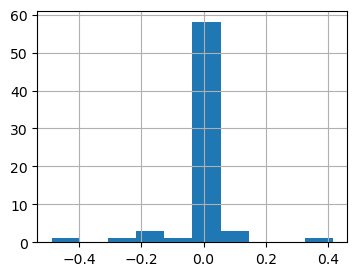

In [81]:
plt.figure(figsize = (4, 3))
df_corr_with_targ['corr_with_target'].hist()

#### Features selection

In [82]:
# ********* Gini of factors: *********

feature_columns = X_not_target.columns
print(len(feature_columns))

68


In [83]:
# X_not_target.info()

In [84]:
# X_not_target['index']

In [85]:
d_gini_by_feature = {}

for feature in feature_columns:
    
    min_value = X_not_target[feature].min()
    
    if min_value >= 0:
        auc = roc_auc_score(y, X_not_target[feature].fillna(-9999))
        
    else:
        idx = X_not_target[feature].notna()
        auc = roc_auc_score(y[idx], X_not_target[feature][idx])        
    
    max_auc = auc if auc > (1 - auc) else (1 - auc)
#   gini = 2 * max(auc, 1 - auc) - 1
    gini = 2 * max_auc - 1
    
    d_gini_by_feature[feature] = gini

# d_gini_by_feature
# ******************************************************************

gini_by_feature = pd.DataFrame(d_gini_by_feature, index = ['gini']).T

gini_by_feature = gini_by_feature.sort_values('gini', ascending = False)
gini_by_feature

,gini
MSP_TYPE_micro,0.793740
MSP_IN_DATE_dist,0.534137
STATEDCAPITAL,0.447627
MSP_TYPE_middle,0.295342
AGE,0.262464
...,...
REGION_TYPE_край,0.000317
OKVED_CHAPTER_CODE_O,0.000260
REGION_TYPE_чувашия,0.000147
OKVED_CHAPTER_CODE_T,0.000038


<Axes: >

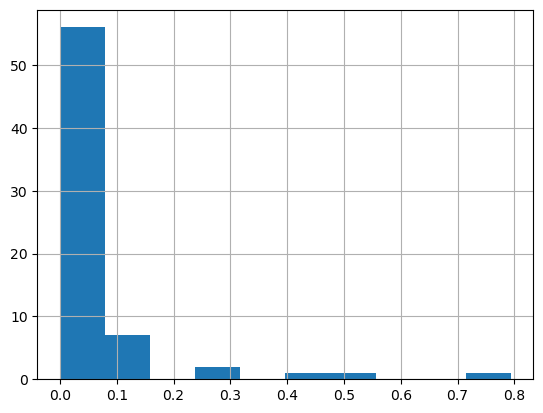

In [86]:
# plt.figure(figsize = (3, 2))
gini_by_feature['gini'].hist()

In [87]:
feature_columns = gini_by_feature.loc[(gini_by_feature['gini'] > 0.005)].index.tolist()

# for col in ['call_cc_flag', 'call_do_flag', 'sms_flag']:
#     if col not in feature_columns:
#         feature_columns.append(col)
        
print('Оставляем {} фичей из {}'.format(len(feature_columns), gini_by_feature.shape[0]))
feature_columns

print(X_not_target.shape)
X_not_target = X_not_target[feature_columns]
print(X_not_target.shape)

Оставляем 52 фичей из 68
(826761, 68)
(826761, 52)


#### Correlations

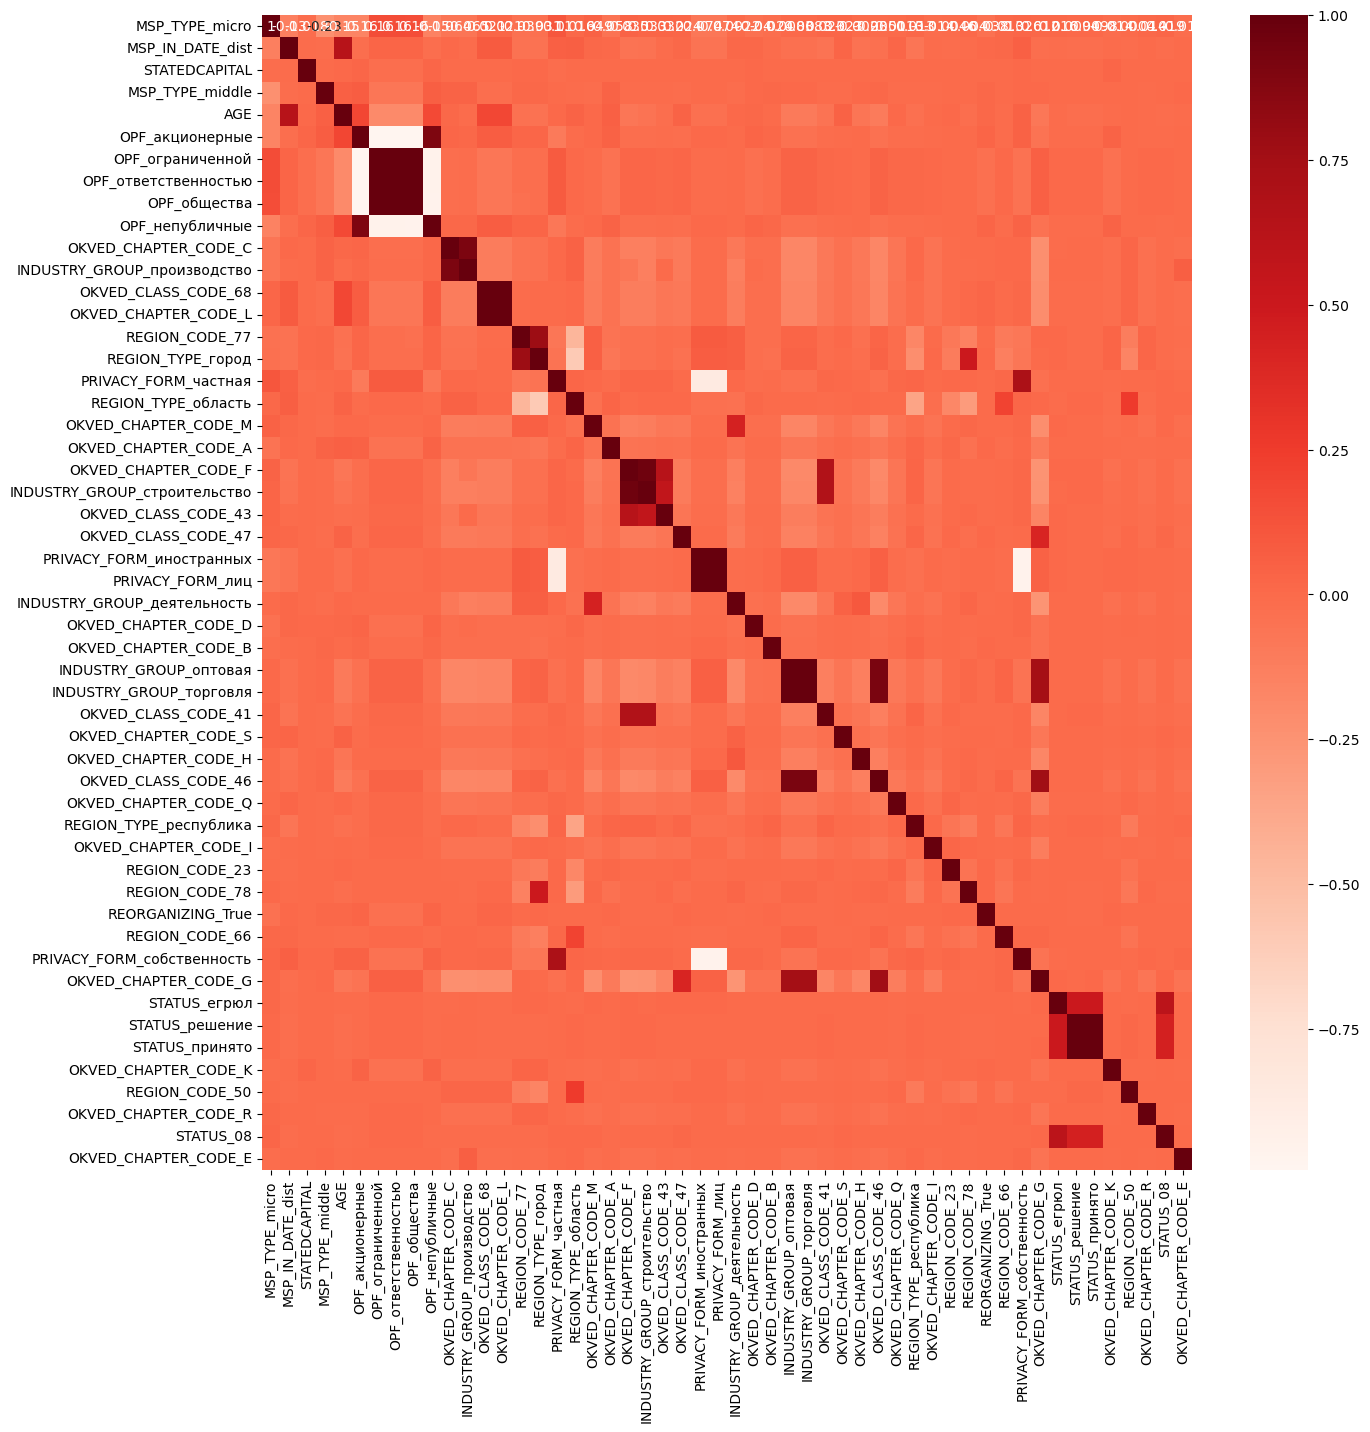

In [88]:
# Выведем матрицу корреляций и удалим зависиммые переменные:

plt.figure(figsize = (15, 15))

cor = X_not_target.corr()
sns.heatmap(cor, annot = True, cmap = plt.cm.Reds)
plt.show()

In [89]:
cnt = 0

for i in range(0, cor.shape[0]):
    for j in range(0, cor.shape[1]):
        
#         if (i > j) & (abs(cor.iloc[i,j]) > 0.9):
        if (i > j) & ( (cor.iloc[i,j] > 0.9) | (cor.iloc[i,j] < -0.9) ):
            cnt += 1
            print('corr(', cor.index[i], ',', cor.columns[j], ') = ', cor.iloc[i][j])
        
print(cnt) 

corr( OPF_ограниченной , OPF_акционерные ) =  -0.9929498270111565
corr( OPF_ответственностью , OPF_акционерные ) =  -0.9929498270111565
corr( OPF_ответственностью , OPF_ограниченной ) =  1.0
corr( OPF_общества , OPF_акционерные ) =  -0.9873086645141267
corr( OPF_общества , OPF_ограниченной ) =  0.9991729420508326
corr( OPF_общества , OPF_ответственностью ) =  0.9991729420508326
corr( OPF_непубличные , OPF_акционерные ) =  0.9050499540749177
corr( OPF_непубличные , OPF_ограниченной ) =  -0.9490829267167872
corr( OPF_непубличные , OPF_ответственностью ) =  -0.9490829267167872
corr( OPF_непубличные , OPF_общества ) =  -0.9611077116599309
corr( INDUSTRY_GROUP_производство , OKVED_CHAPTER_CODE_C ) =  0.9068653487495285
corr( OKVED_CHAPTER_CODE_L , OKVED_CLASS_CODE_68 ) =  1.0
corr( INDUSTRY_GROUP_строительство , OKVED_CHAPTER_CODE_F ) =  0.9667192823691185
corr( PRIVACY_FORM_лиц , PRIVACY_FORM_иностранных ) =  1.0
corr( INDUSTRY_GROUP_торговля , INDUSTRY_GROUP_оптовая ) =  1.0
corr( OKVED_C

In [90]:
# + Удаление сильно коррелирующих признаков

THRESHOLD_FOR_CORRELATION = 0.98

feature_columns = list(X_not_target.columns)

# correlation_matrix = df[L1_columns].corr()
correlation_matrix = X_not_target.corr()

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k = 1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > THRESHOLD_FOR_CORRELATION)]

feature_after_corr = [col for col in feature_columns if col not in to_drop]

print('По корреляции оставляем {} фичей из {}'.format( len(feature_after_corr), len(feature_columns) ))

По корреляции оставляем 46 фичей из 52


In [91]:
print(X_not_target.shape)
X_not_target = X_not_target[feature_after_corr]
print(X_not_target.shape)

(826761, 52)
(826761, 46)


In [92]:
cor = X_not_target.corr()
cnt = 0

for i in range(0, cor.shape[0]):
    for j in range(0, cor.shape[1]):
        
#         if (i > j) & (abs(cor.iloc[i,j]) > 0.9):
        if (i > j) & ( (cor.iloc[i,j] > 0.9) | (cor.iloc[i,j] < -0.9) ):
            cnt += 1
            print('corr(', cor.index[i], ',', cor.columns[j], ') = ', cor.iloc[i][j])
        
print(cnt) 

corr( OPF_ограниченной , OPF_акционерные ) =  -0.9929498270111565
corr( OPF_непубличные , OPF_акционерные ) =  0.9050499540749177
corr( OPF_непубличные , OPF_ограниченной ) =  -0.9490829267167872
corr( INDUSTRY_GROUP_производство , OKVED_CHAPTER_CODE_C ) =  0.9068653487495285
corr( INDUSTRY_GROUP_строительство , OKVED_CHAPTER_CODE_F ) =  0.9667192823691185
corr( OKVED_CLASS_CODE_46 , INDUSTRY_GROUP_оптовая ) =  0.9166647815423598
corr( PRIVACY_FORM_собственность , PRIVACY_FORM_иностранных ) =  -0.9546237939145965
7


#### L1 regularization

In [93]:
# from sklearn.linear_model import LogisticRegression

# classifier = LogisticRegression(penalty = 'l1', solver = 'liblinear')

# classifier.fit(X_not_target, y)

# columns = X_not_target.columns

# df_var_L1 = pd.concat([pd.DataFrame(columns).rename(columns = {0:'var'}), 
#            pd.DataFrame(classifier.coef_).T.rename(columns = {0:'coef'})], axis = 1).sort_values(by = 'coef', ascending = False)
# df_var_L1

# # Выберем признаки с коэффицентами != 0:
# df_L1 = df_var_L1[ df_var_L1['coef'] != 0 ]

# print(df_L1.shape)
# # df_L1.sort_values(by = 'coef', ascending = False)

# features_L1 = list(df_L1['var'])
# print(len(features_L1))
# features_L1

#### Fillna

In [94]:
cat_vars = X_not_target.select_dtypes(include  = [object]).columns
num_vars = X_not_target.select_dtypes(include = [np.number]).columns

X_not_target[cat_vars] = X_not_target[cat_vars].fillna('_miss',axis = 1)
X_not_target[num_vars] = X_not_target[num_vars].fillna(0, axis = 1)

#### Backward Elimination

In [98]:
# import statsmodels
# import statsmodels.api as sm

def BE_func(var, y):
    
    cols = var
    pmax = 1
    
    while (len(cols) > 0):
        p = []
#         X_1 = df_BE[cols]
        X_1 = X_not_target[cols]
        
#       ****** Linear model: *******
        # X_1 = sm.add_constant(X_1)
        # model = sm.OLS(y.astype(float), X_1.astype(float)).fit()

#       *********** Classification model: *************
        model = sm.Logit(y, sm.add_constant(X_1)).fit()
        model = statsmodels.discrete.discrete_model.Logit(y, sm.add_constant(X_1)).fit()
        # print(model.summary())
        
        p = pd.Series(model.pvalues.values[1:], index = cols)      
        pmax = p.max()
        feature_with_p_max = p.idxmax()
        
        if(pmax > 0.05):
#         if(pmax > 0.1):
            # cols.remove(feature_with_p_max)
            cols = [i for i in cols if i not in feature_with_p_max]
        else:
            break
    selected_features_BE = cols
    
#     print(len(selected_features_BE))
#     print(list(selected_features_BE))
    return selected_features_BE

In [99]:
X_not_target.shape

(826761, 46)

In [100]:
# Backward Elimination: 

columns = X_not_target.columns
# columns = features_L1                                          

selected_features_BE_all = BE_func(columns, y)

Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041287
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.041288
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.

In [101]:
print(len(selected_features_BE_all))
set(X_not_target.columns) - set(selected_features_BE_all)
# selected_features_BE_all

34


{'INDUSTRY_GROUP_деятельность',
 'INDUSTRY_GROUP_производство',
 'INDUSTRY_GROUP_строительство',
 'OKVED_CHAPTER_CODE_Q',
 'OKVED_CLASS_CODE_46',
 'OPF_акционерные',
 'REGION_CODE_23',
 'REGION_CODE_66',
 'REGION_CODE_77',
 'REGION_CODE_78',
 'REGION_TYPE_город',
 'STATUS_решение'}

In [171]:
print(len(selected_features_BE_all))
selected_features_BE_all

34


['MSP_TYPE_micro',
 'MSP_IN_DATE_dist',
 'STATEDCAPITAL',
 'MSP_TYPE_middle',
 'AGE',
 'OPF_ограниченной',
 'OPF_непубличные',
 'OKVED_CHAPTER_CODE_C',
 'OKVED_CLASS_CODE_68',
 'PRIVACY_FORM_частная',
 'REGION_TYPE_область',
 'OKVED_CHAPTER_CODE_M',
 'OKVED_CHAPTER_CODE_A',
 'OKVED_CHAPTER_CODE_F',
 'OKVED_CLASS_CODE_43',
 'OKVED_CLASS_CODE_47',
 'PRIVACY_FORM_иностранных',
 'OKVED_CHAPTER_CODE_D',
 'OKVED_CHAPTER_CODE_B',
 'INDUSTRY_GROUP_оптовая',
 'OKVED_CLASS_CODE_41',
 'OKVED_CHAPTER_CODE_S',
 'OKVED_CHAPTER_CODE_H',
 'REGION_TYPE_республика',
 'OKVED_CHAPTER_CODE_I',
 'REORGANIZING_True',
 'PRIVACY_FORM_собственность',
 'OKVED_CHAPTER_CODE_G',
 'STATUS_егрюл',
 'OKVED_CHAPTER_CODE_K',
 'REGION_CODE_50',
 'OKVED_CHAPTER_CODE_R',
 'STATUS_08',
 'OKVED_CHAPTER_CODE_E']

In [166]:
# print(len(selected_features_BE_all))

# selected_features_BE_all = ['MSP_TYPE_micro',
#  'MSP_IN_DATE_dist',
#  'STATEDCAPITAL',
#  'MSP_TYPE_middle',
#  'AGE',
#  'OPF_ограниченной',
#  'OPF_непубличные',
#  'OKVED_CHAPTER_CODE_C',
#  'OKVED_CLASS_CODE_68',
#  'PRIVACY_FORM_частная',
#  'REGION_TYPE_область',
#  'OKVED_CHAPTER_CODE_M',
#  'OKVED_CHAPTER_CODE_A',
#  'OKVED_CHAPTER_CODE_F',
#  'OKVED_CLASS_CODE_43',
#  'OKVED_CLASS_CODE_47',
#  'PRIVACY_FORM_иностранных',
#  'OKVED_CHAPTER_CODE_D',
#  'OKVED_CHAPTER_CODE_B',
#  'INDUSTRY_GROUP_оптовая',
#  'OKVED_CLASS_CODE_41',
#  'OKVED_CHAPTER_CODE_S',
#  'OKVED_CHAPTER_CODE_H',
#  'REGION_TYPE_республика',
#  'OKVED_CHAPTER_CODE_I',
#  'REORGANIZING_True',
#  'PRIVACY_FORM_собственность',
#  'OKVED_CHAPTER_CODE_G',
#  'STATUS_егрюл',
#  'OKVED_CHAPTER_CODE_K',
#  'REGION_CODE_50',
#  'OKVED_CHAPTER_CODE_R',
#  'STATUS_08',
#  'OKVED_CHAPTER_CODE_E']

34


#### L1 Regularization

In [103]:
# # from sklearn.linear_model import LogisticRegression

# classifier = LogisticRegression(penalty = 'l1', solver = 'liblinear')

# classifier.fit(X_not_target[selected_features_BE_all], y)

# columns = X_not_target[selected_features_BE_all].columns

# df_var_L1 = pd.concat([pd.DataFrame(columns).rename(columns = {0:'var'}), 
#            pd.DataFrame(classifier.coef_).T.rename(columns = {0:'coef'})], axis = 1).sort_values(by = 'coef', ascending = False)
# df_var_L1

# # Выберем признаки с коэффицентами != 0:
# df_L1 = df_var_L1[ df_var_L1['coef'] != 0 ]

# print(df_L1.shape)
# # df_L1.sort_values(by = 'coef', ascending = False)

# features_corr_BE_L1 = list(df_L1['var'])
# print(len(features_corr_BE_L1))
# features_corr_BE_L1

In [105]:
selected_features_BE_all

['MSP_TYPE_micro',
 'MSP_IN_DATE_dist',
 'STATEDCAPITAL',
 'MSP_TYPE_middle',
 'AGE',
 'OPF_ограниченной',
 'OPF_непубличные',
 'OKVED_CHAPTER_CODE_C',
 'OKVED_CLASS_CODE_68',
 'PRIVACY_FORM_частная',
 'REGION_TYPE_область',
 'OKVED_CHAPTER_CODE_M',
 'OKVED_CHAPTER_CODE_A',
 'OKVED_CHAPTER_CODE_F',
 'OKVED_CLASS_CODE_43',
 'OKVED_CLASS_CODE_47',
 'PRIVACY_FORM_иностранных',
 'OKVED_CHAPTER_CODE_D',
 'OKVED_CHAPTER_CODE_B',
 'INDUSTRY_GROUP_оптовая',
 'OKVED_CLASS_CODE_41',
 'OKVED_CHAPTER_CODE_S',
 'OKVED_CHAPTER_CODE_H',
 'REGION_TYPE_республика',
 'OKVED_CHAPTER_CODE_I',
 'REORGANIZING_True',
 'PRIVACY_FORM_собственность',
 'OKVED_CHAPTER_CODE_G',
 'STATUS_егрюл',
 'OKVED_CHAPTER_CODE_K',
 'REGION_CODE_50',
 'OKVED_CHAPTER_CODE_R',
 'STATUS_08',
 'OKVED_CHAPTER_CODE_E']

In [106]:
# X_not_target = X_not_target[features_corr_BE_L1]
X_not_target = X_not_target[selected_features_BE_all]

print(X_not_target.shape)

# X_train, X_test, y_train, y_test = train_test_split(X_not_target, y, test_size = 0.20, random_state = 42, stratify = y)
X_train, X_test, y_train, y_test = train_test_split(X_not_target, y, test_size = 0.15, random_state = 42, stratify = y)

print(X_train.shape, X_test.shape)
print(y_train.mean(), y_test.mean())

(826761, 34)
(702746, 34) (124015, 34)
0.01728647334883443 0.017288231262347298


In [107]:
clf_lgb = lgb.LGBMClassifier()

clf_lgb.fit(X_train, y_train)

print('\n')
y_pred_train = clf_lgb.predict_proba(X_train)[:,1]
AUC_train = metrics.roc_auc_score(y_train, y_pred_train)
Gini_train = 2 * AUC_train - 1
print('AUC_train:', AUC_train)
print('Gini_train:', Gini_train)

print()

y_pred_test = clf_lgb.predict_proba(X_test)[:,1]
AUC_test = metrics.roc_auc_score(y_test, y_pred_test)
Gini_test = 2 * AUC_test - 1
print('AUC_test:', AUC_test)
print('Gini_test:', Gini_test)

[LightGBM] [Info] Number of positive: 12148, number of negative: 690598
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 702746, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017286 -> initscore=-4.040393
[LightGBM] [Info] Start training from score -4.040393


AUC_train: 0.9718370930683474
Gini_train: 0.9436741861366948

AUC_test: 0.963576213660958
Gini_test: 0.927152427321916


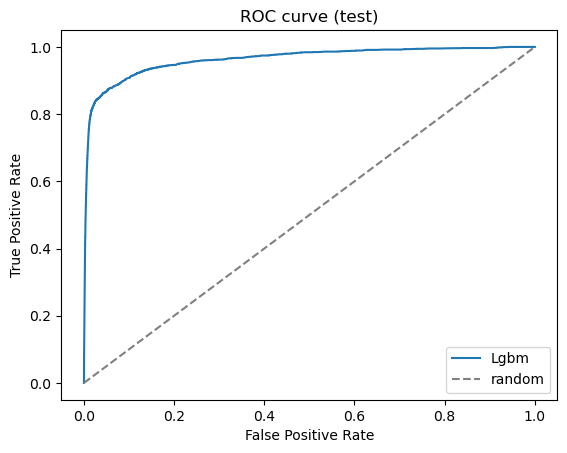

In [108]:
# import matplotlib.pyplot as plt
# %matplotlib inline
# %pylab inline

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_test)

pylab.plot(fpr, tpr, label = 'Lgbm')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve (test)')
pylab.legend(loc = "lower right")

In [109]:
# from sklearn import model_selection, datasets, linear_model, metrics

kfold = model_selection.KFold(n_splits = 4)

# AUC_cv = cross_val_score(clf_lgb, X_not_target[features_corr_BE_L1], y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
AUC_cv = cross_val_score(clf_lgb, X_not_target[selected_features_BE_all], y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
AUC_cv

array([0.96199176, 0.96320497, 0.96275306, 0.96419764])

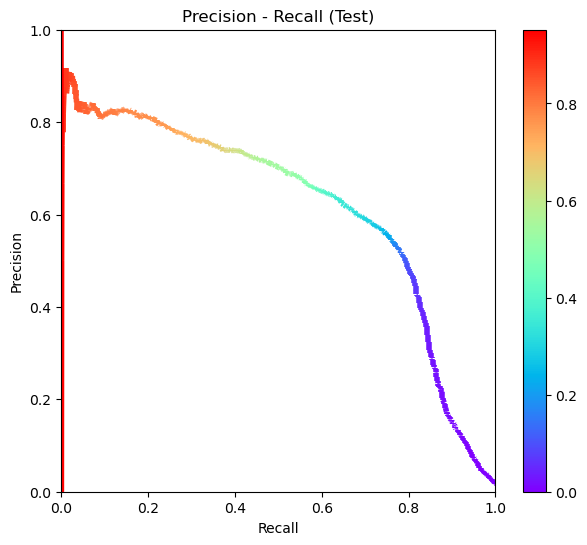

In [110]:
# Precision recall curve
# from sklearn.metrics import precision_recall_curve

precision1, recall1, threshold1 = precision_recall_curve( y_test, y_pred_test )

from matplotlib.collections import LineCollection

x    = recall1
y_pr    = precision1
cols = threshold1

points = np.array([x, y_pr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis = 1)

fig, ax = plt.subplots(figsize = (7, 6))
#lc = LineCollection(segments, cmap ='viridis')
lc = LineCollection(segments, cmap = plt.cm.rainbow)

lc.set_array(cols)
lc.set_linewidth(4)
line = ax.add_collection(lc)
fig.colorbar(line, ax = ax)

#plt.figure(figsize = [15,15])

plt.xlabel("Recall")
plt.ylabel("Precision")
pylab.title('Precision - Recall (Test)')
plt.show()

In [111]:
y_pred_train_class = clf_lgb.predict(X_train)
AUC_train_class = metrics.roc_auc_score(y_train, y_pred_train_class)

Gini_train_class = 2 * AUC_train_class - 1
print('AUC_train_class:', AUC_train_class)
print('Gini_train_class:', Gini_train_class)

print()

y_pred_test_class = clf_lgb.predict(X_test)
AUC_test_class = metrics.roc_auc_score(y_test, y_pred_test_class)
Gini_test_class = 2 * AUC_test_class - 1
print('AUC_test_class:', AUC_test_class)
print('Gini_test_class:', Gini_test_class)

AUC_train_class: 0.7798096617076927
Gini_train_class: 0.5596193234153855

AUC_test_class: 0.7731304702139784
Gini_test_class: 0.5462609404279568


In [112]:
print(len(X_not_target.columns))
X_not_target.columns

34


Index(['MSP_TYPE_micro', 'MSP_IN_DATE_dist', 'STATEDCAPITAL',
       'MSP_TYPE_middle', 'AGE', 'OPF_ограниченной', 'OPF_непубличные',
       'OKVED_CHAPTER_CODE_C', 'OKVED_CLASS_CODE_68', 'PRIVACY_FORM_частная',
       'REGION_TYPE_область', 'OKVED_CHAPTER_CODE_M', 'OKVED_CHAPTER_CODE_A',
       'OKVED_CHAPTER_CODE_F', 'OKVED_CLASS_CODE_43', 'OKVED_CLASS_CODE_47',
       'PRIVACY_FORM_иностранных', 'OKVED_CHAPTER_CODE_D',
       'OKVED_CHAPTER_CODE_B', 'INDUSTRY_GROUP_оптовая', 'OKVED_CLASS_CODE_41',
       'OKVED_CHAPTER_CODE_S', 'OKVED_CHAPTER_CODE_H',
       'REGION_TYPE_республика', 'OKVED_CHAPTER_CODE_I', 'REORGANIZING_True',
       'PRIVACY_FORM_собственность', 'OKVED_CHAPTER_CODE_G', 'STATUS_егрюл',
       'OKVED_CHAPTER_CODE_K', 'REGION_CODE_50', 'OKVED_CHAPTER_CODE_R',
       'STATUS_08', 'OKVED_CHAPTER_CODE_E'],
      dtype='object')

In [179]:
cm = metrics.confusion_matrix(y_test, y_pred_test_class)
print(cm)

TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print('TP:', TP)
print('FP:', FP)

[[121313    558]
 [   963   1181]]
TP: 1181
FP: 558


In [180]:
metrics.accuracy_score(y_test, y_pred_test_class)

0.9877353545942024

In [181]:
print(metrics.classification_report(y_test, y_pred_test_class))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    121871
           1       0.68      0.55      0.61      2144

    accuracy                           0.99    124015
   macro avg       0.84      0.77      0.80    124015
weighted avg       0.99      0.99      0.99    124015



In [182]:
X_not_target.shape

(826761, 34)

In [201]:
y_pred_all = clf_lgb.predict_proba(X_not_target)[:,1]

p, r, thresholds = precision_recall_curve(y, y_pred_all)

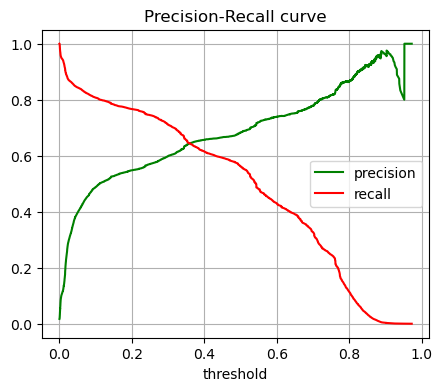

In [203]:
plt.figure(figsize = (5, 4))
plt.grid(True)

plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")

plt.legend(['precision','recall'])
plt.title('Precision-Recall curve')

plt.xlabel("threshold")
plt.show()

In [208]:
len(y_pred_all)

826761

In [185]:
y_pred_all_df = pd.DataFrame(y_pred_all)
y_pred_all_df.rename(columns = {0: 'predict'}, inplace = True)
y_pred_all_df.head()

,predict
0,0.832180
1,0.000823
2,0.009037
3,0.000040
4,0.000734


In [186]:
def dependency_volume_threshold(y_pred_all):

    list_thresholds, list_number = [], []
    
    # for th_i in range(0, 10):
    for th_i in range(1, 10):

        th_i = th_i / 10

        y_pred_all_01_i = y_pred_all['predict'].apply(lambda x: 1 if x >= th_i else 0)
        
        confusion_i = metrics.confusion_matrix(y, y_pred_all_01_i)

        TP_i, FP_i, TN_i, FN_i = confusion_i[1,1], confusion_i[0,1], confusion_i[0,0], confusion_i[1,0]
        number_i = TP_i + FP_i
        list_thresholds.append(th_i)
        list_number.append(number_i)

    d = {'thresholds': list_thresholds, 'number': list_number}
    df_th_num = pd.DataFrame(d)

    return df_th_num
        
df_th_num = dependency_volume_threshold(y_pred_all_df)
df_th_num

,thresholds,number
0,0.1,23618
1,0.2,19994
2,0.3,16977
3,0.4,13386
4,0.5,11762
5,0.6,8304
6,0.7,6002
7,0.8,1875
8,0.9,50


In [187]:
y.sum()

14292

Text(0.5, 0, 'threshold')

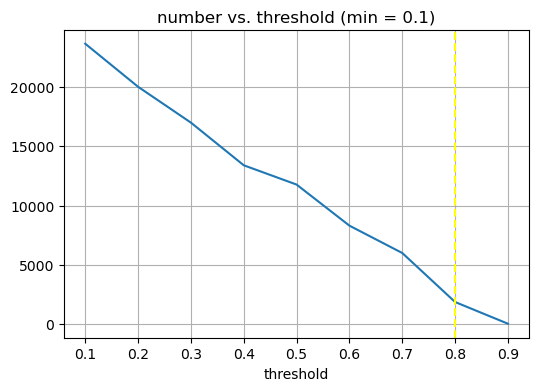

In [204]:
# df_th_num.plot()

plt.figure(figsize = (6, 4))

plt.plot(df_th_num['thresholds'], df_th_num['number'])
plt.axvline(x = 0.8, color = 'yellow', linestyle = '--')

plt.grid()
plt.title('number vs. threshold (min = 0.1)')
plt.xlabel("threshold")

Text(0.5, 0, 'threshold')

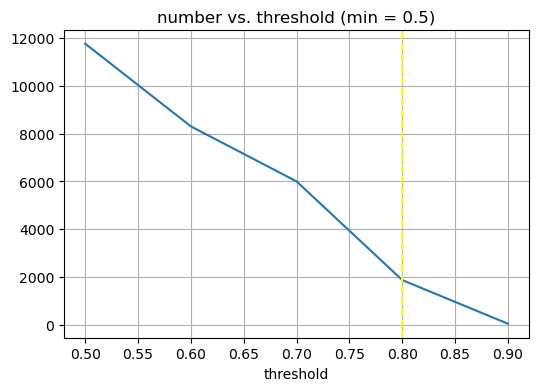

In [205]:
plt.figure(figsize = (6, 4))

plt.plot(df_th_num[df_th_num['thresholds'] >= 0.5]['thresholds'], 
         df_th_num[df_th_num['thresholds'] >= 0.5]['number'])

plt.axvline(x = 0.8, color = 'yellow', linestyle = '--')

plt.grid()
plt.title('number vs. threshold (min = 0.5)')
plt.xlabel("threshold")

In [190]:
y_pred_all = pd.DataFrame(y_pred_all).rename(columns = {0: 'predict'})

y_pred_all_01 = y_pred_all['predict'].apply(lambda x: 1 if x >= 0.8 else 0)
# y_pred_all_01

In [125]:
confusion = metrics.confusion_matrix(y, y_pred_all_01)
confusion

array([[812218,    251],
       [ 12668,   1624]])

In [126]:
len(y)

826761

In [127]:
# (1718 + 343) / 918738

In [128]:
# TP, FP, TN, FN = confusion[1,1], confusion[0,1], confusion[0,0], confusion[1,0]

In [129]:
# Precision:
# TP / TP + FP

Precision = confusion[1,1]/(confusion[0,1] + confusion[1,1])
Precision

0.8661333333333333

In [130]:
# Recall:
# TP / TP + FN

Recall = confusion[1,1]/(confusion[1,0] + confusion[1,1])
Recall

0.11363000279876855

In [131]:
F = 2 * Precision * Recall / (Precision + Recall)
F

0.20090307416341932

In [164]:
# import pickle

# **************** save model 12.05: *****************

# with open('model_LA_galaxy_targ2024_v2.pkl', 'wb') as fid:

#         pickle.dump(clf_lgb, fid)

# ********************* read: ************************

# with open('model_LA_galaxy_targ2024_v2.pkl', 'rb') as fid:
    
#     clf_lgb = pickle.load(fid)

In [133]:
clf_lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [134]:
clf_lgb.feature_importances_

array([ 95, 350, 646,  80, 844,  24,  20,  28, 118,  21,  99,  46,  12,
        24,  22,  50,  32,  18,  22,  47,  33,  32,  26,  62,  23,  21,
        36,  53,  32,  28,  20,  25,   0,  11], dtype=int32)

In [135]:
len(selected_features_BE_all)

34

In [136]:
X_not_target.shape

(826761, 34)

Text(0.5, 0, 'feature_importance')

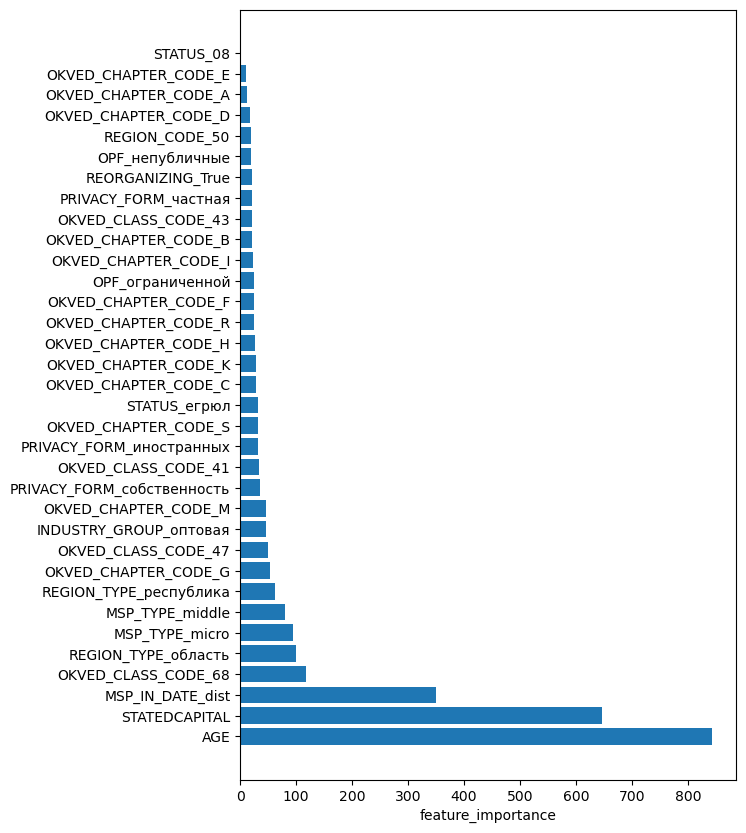

In [214]:
importances = clf_lgb.feature_importances_

# indices = np.argsort(importances)
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots()

ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))

_ = ax.set_yticklabels(np.array(X_not_target.columns)[indices])

fig.set_figheight(10)
plt.xlabel("feature_importance")

In [200]:
df['PRIVACY_FORM'].value_counts()

Частная собственность                                                                                                   926067
Собственность иностранных граждан и лиц без гражданства                                                                  12049
Совместная частная и иностранная собственность                                                                            6297
Собственность иностранных юридических лиц                                                                                 3406
Муниципальная собственность                                                                                               1058
Иная смешанная российская собственность                                                                                    924
Смешанная российская собственность с долей федеральной собственности                                                       660
Собственность субъектов Российской Федерации                                                                   

25/05/14 09:26:06 ERROR YarnScheduler: Lost executor 6 on hdp3-llap-1.dmp.vimpelcom.ru: Executor heartbeat timed out after 179007 ms


In [138]:
print(len(X_not_target))
X_not_target.columns

826761


Index(['MSP_TYPE_micro', 'MSP_IN_DATE_dist', 'STATEDCAPITAL',
       'MSP_TYPE_middle', 'AGE', 'OPF_ограниченной', 'OPF_непубличные',
       'OKVED_CHAPTER_CODE_C', 'OKVED_CLASS_CODE_68', 'PRIVACY_FORM_частная',
       'REGION_TYPE_область', 'OKVED_CHAPTER_CODE_M', 'OKVED_CHAPTER_CODE_A',
       'OKVED_CHAPTER_CODE_F', 'OKVED_CLASS_CODE_43', 'OKVED_CLASS_CODE_47',
       'PRIVACY_FORM_иностранных', 'OKVED_CHAPTER_CODE_D',
       'OKVED_CHAPTER_CODE_B', 'INDUSTRY_GROUP_оптовая', 'OKVED_CLASS_CODE_41',
       'OKVED_CHAPTER_CODE_S', 'OKVED_CHAPTER_CODE_H',
       'REGION_TYPE_республика', 'OKVED_CHAPTER_CODE_I', 'REORGANIZING_True',
       'PRIVACY_FORM_собственность', 'OKVED_CHAPTER_CODE_G', 'STATUS_егрюл',
       'OKVED_CHAPTER_CODE_K', 'REGION_CODE_50', 'OKVED_CHAPTER_CODE_R',
       'STATUS_08', 'OKVED_CHAPTER_CODE_E'],
      dtype='object')

In [139]:
feature_columns = list(X_not_target.columns)

In [140]:
variable_importance = pd.DataFrame(sorted(zip(clf_lgb.feature_importances_, feature_columns), reverse=True))
variable_importance.columns = ['gain', 'feature']

variable_importance['gain_share'] = variable_importance['gain'] / variable_importance['gain'].sum()

variable_importance = variable_importance[['feature', 'gain', 'gain_share']]

variable_importance

,feature,gain,gain_share
0,AGE,844,0.281333
1,STATEDCAPITAL,646,0.215333
2,MSP_IN_DATE_dist,350,0.116667
3,OKVED_CLASS_CODE_68,118,0.039333
4,REGION_TYPE_область,99,0.033000
5,MSP_TYPE_micro,95,0.031667
6,MSP_TYPE_middle,80,0.026667
7,REGION_TYPE_республика,62,0.020667
8,OKVED_CHAPTER_CODE_G,53,0.017667
9,OKVED_CLASS_CODE_47,50,0.016667


#### SHAP values

In [141]:
# pip install --upgrade shap

/home/ezagaynaya/.local/lib/python3.10/site-packages/shap/explainers/_tree.py:544: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


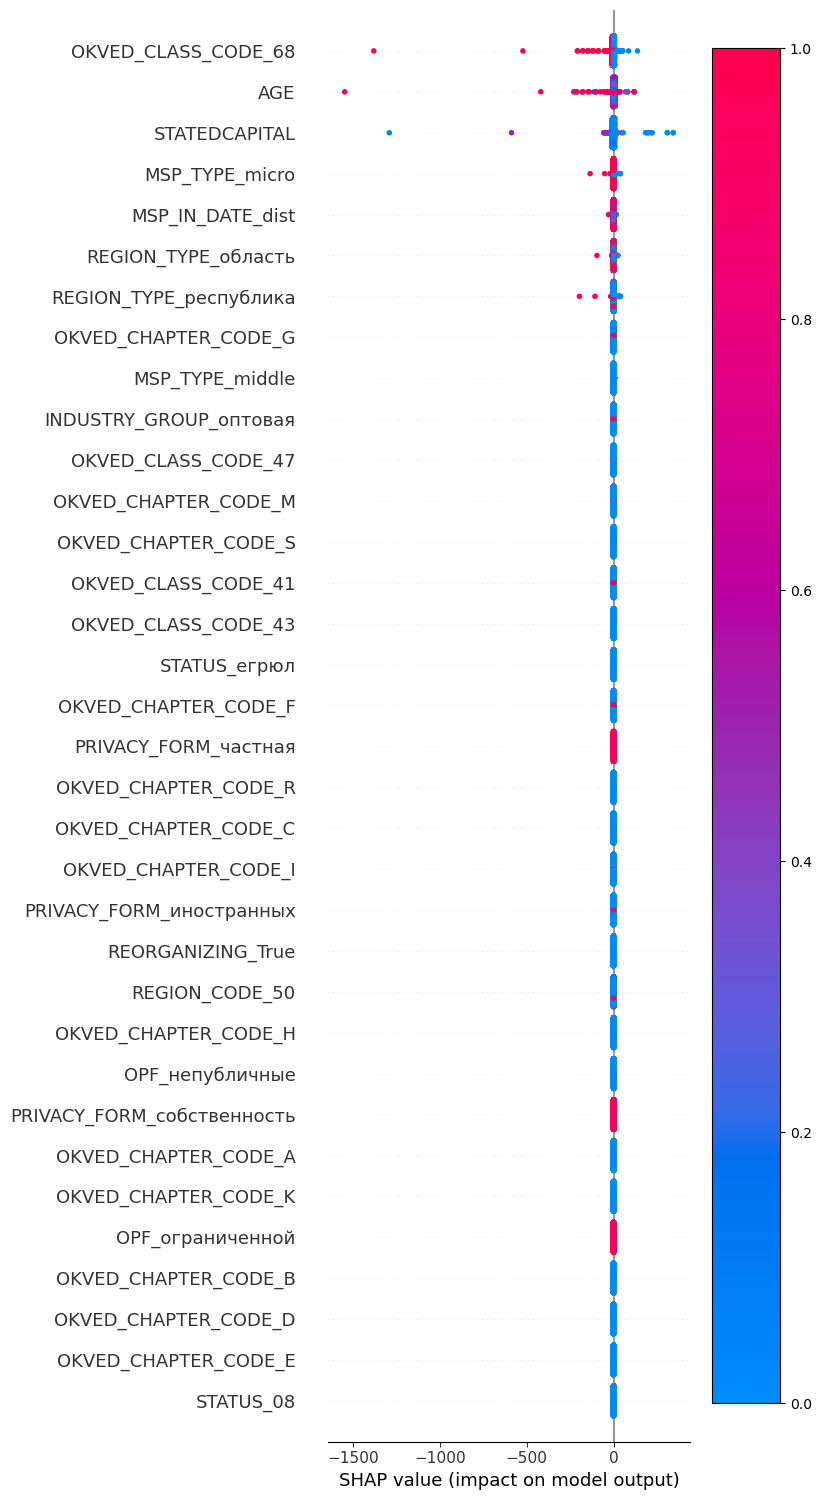

In [142]:
# Generate SHAP summary plots

import shap
from matplotlib.cm import ScalarMappable

feature_columns = X_not_target.columns

def generate_output_summary_plot(model_object, x_train, features, sample_size = 10**4):
    
    x_train = x_train.sample(sample_size)[features]
    
    explainer = shap.TreeExplainer(model_object)
    # shap_values = explainer.shap_values(x_train)[1]
    shap_values = explainer.shap_values(x_train)

    shap.summary_plot(shap_values, x_train, max_display = 50, show=False, color_bar=False)
    
    plt.colorbar()
    plt.show()
    

generate_output_summary_plot(clf_lgb, X_not_target, feature_columns, sample_size = 10**4)

In [143]:
# Validation sample:

# X_y_test_last = pd.read_pickle('X_y_test_last_LA_2024_v3.pkl')
# print(X_y_test_last.shape)
# X_y_test_last.head(2)

In [144]:
# # ********************* read transformer: ********************
# with open('TF_IDF_vectorizer_v3.pkl', 'rb') as fid:
#     vectorizer = pickle.load(fid)

In [145]:
all_features = ['OPF',
 'REGION_CODE',
 'STATUS',
 'PRIVACY_FORM',
 'OKVED_CLASS_CODE',
 'INDUSTRY_GROUP']

for i in range(len(all_features)):

    feature = all_features[i]
    texts = X_y_test_last[feature].fillna('-1')

    tfidf_matrix = vectorizer.transform(texts)
    
    # Convert to DataFrame:
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = vectorizer.get_feature_names_out())
    tfidf_df.columns = [feature + '_' + col for col in tfidf_df.columns ]

    X_y_test_last.drop(feature, axis = 1, inplace = True)
    X_y_test_last = pd.concat([X_y_test_last, tfidf_df], axis = 1)

print(X_y_test_last.shape)
X_y_test_last.head(3)

(91863, 69)


,AGE,STATEDCAPITAL,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,STATUS_DATE_dist,REGION_TYPE_автономная область,REGION_TYPE_автономный округ,REGION_TYPE_город,REGION_TYPE_край,REGION_TYPE_область,...,OKVED_CLASS_CODE_деятельность,OKVED_CLASS_CODE_оптовая,OKVED_CLASS_CODE_производство,OKVED_CLASS_CODE_строительство,OKVED_CLASS_CODE_торговля,INDUSTRY_GROUP_деятельность,INDUSTRY_GROUP_оптовая,INDUSTRY_GROUP_производство,INDUSTRY_GROUP_строительство,INDUSTRY_GROUP_торговля
0,9.4,20000.0,105.0,NaN,NaN,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000
1,5.2,10000.0,63.0,NaN,NaN,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000
2,2.1,600000.0,25.0,NaN,NaN,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107


In [146]:
69 - 45

24

In [147]:
# X_y_test_last['index']

In [148]:
# X.drop(feature, axis = 1, inplace = True)
# tfidf_df.reset_index(inplace = True, drop = True)
# # print(X.shape)
# X = pd.concat([X, tfidf_df], axis = 1)
# # print(X.shape)

In [149]:
cat_vars = X_y_test_last.select_dtypes(include  = [object]).columns
num_vars = X_y_test_last.select_dtypes(include = [np.number]).columns

X_y_test_last[cat_vars] = X_y_test_last[cat_vars].fillna('_miss',axis = 1)
X_y_test_last[num_vars] = X_y_test_last[num_vars].fillna(0, axis = 1)

In [150]:
X_y_test_last['REVENUE'].head(2)

0    0.0
1    0.0
Name: REVENUE, dtype: float64

In [151]:
print(len(set(selected_features_BE_all) - set(X_y_test_last.columns)))
set(selected_features_BE_all) - set(X_y_test_last.columns)

12


{'OKVED_CLASS_CODE_41',
 'OKVED_CLASS_CODE_43',
 'OKVED_CLASS_CODE_47',
 'OKVED_CLASS_CODE_68',
 'OPF_непубличные',
 'OPF_ограниченной',
 'PRIVACY_FORM_иностранных',
 'PRIVACY_FORM_собственность',
 'PRIVACY_FORM_частная',
 'REGION_CODE_50',
 'STATUS_08',
 'STATUS_егрюл'}

In [152]:
X_y_test_last.shape

(91863, 69)

In [153]:
# fill 0:
list_0_cols = list(set(selected_features_BE_all) - set(X_y_test_last.columns) )
for i in list_0_cols:
    X_y_test_last[i] = 0

print(X_y_test_last.shape)
X_y_test_last.head(3)

(91863, 81)


,AGE,STATEDCAPITAL,MSP_IN_DATE_dist,MSP_OUT_DATE_dist,STATUS_DATE_dist,REGION_TYPE_автономная область,REGION_TYPE_автономный округ,REGION_TYPE_город,REGION_TYPE_край,REGION_TYPE_область,...,OKVED_CLASS_CODE_68,OKVED_CLASS_CODE_41,OKVED_CLASS_CODE_43,PRIVACY_FORM_частная,OKVED_CLASS_CODE_47,STATUS_егрюл,OPF_непубличные,OPF_ограниченной,PRIVACY_FORM_собственность,PRIVACY_FORM_иностранных
0,9.4,20000.0,105.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,5.2,10000.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2.1,600000.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [154]:
X_valid = X_y_test_last.drop('REVENUE', axis = 1)[selected_features_BE_all]
y_valid = X_y_test_last['REVENUE']

print(X_valid.shape)
print(y_valid.shape)

(91863, 34)
(91863,)


In [155]:
y_pred_valid = clf_lgb.predict_proba(X_valid)[:,1]
AUC_valid = metrics.roc_auc_score(y_valid, y_pred_valid)

Gini_valid = 2 * AUC_valid - 1
print('AUC_valid:', AUC_valid)
print('Gini_valid:', Gini_valid)

AUC_valid: 0.9566436448383647
Gini_valid: 0.9132872896767295


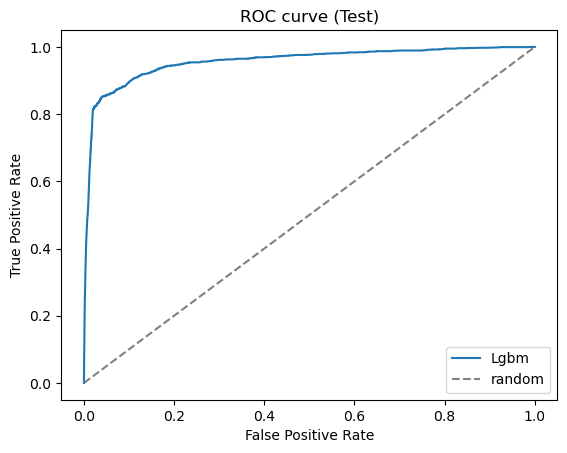

In [207]:
fpr, tpr, _ = metrics.roc_curve(y_valid, y_pred_valid)

pylab.plot(fpr, tpr, label = 'Lgbm')
pylab.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
pylab.xlim([-0.05, 1.05])
pylab.ylim([-0.05, 1.05])
pylab.xlabel('False Positive Rate')
pylab.ylabel('True Positive Rate')
pylab.title('ROC curve (Test)')
pylab.legend(loc = "lower right")

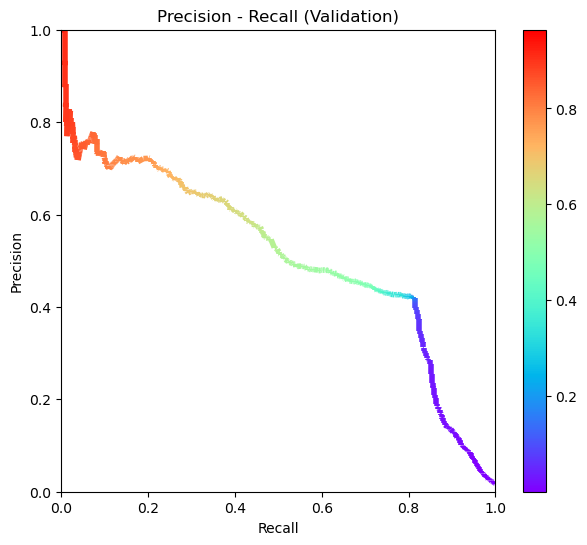

In [206]:
# Precision recall curve
# from sklearn.metrics import precision_recall_curve

precision1, recall1, threshold1 = precision_recall_curve( y_valid, y_pred_valid )

from matplotlib.collections import LineCollection

x    = recall1
y_pr    = precision1
cols = threshold1

points = np.array([x, y_pr]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis = 1)

fig, ax = plt.subplots(figsize = (7, 6))
#lc = LineCollection(segments, cmap ='viridis')
lc = LineCollection(segments, cmap = plt.cm.rainbow)

lc.set_array(cols)
lc.set_linewidth(4)
line = ax.add_collection(lc)
fig.colorbar(line, ax = ax)

#plt.figure(figsize = [15,15])

plt.xlabel("Recall")
plt.ylabel("Precision")
pylab.title('Precision - Recall (Validation)')
plt.show()

In [158]:
y_pred_valid_class = clf_lgb.predict(X_valid)

cm = metrics.confusion_matrix(y_valid, y_pred_valid_class)
print(cm)

TN, FP, FN, TP = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
print('TP:', TP)
print('FP:', FP)

[[88977  1298]
 [  508  1080]]
TP: 1080
FP: 1298


In [159]:
y_pred_valid_ = clf_lgb.predict_proba(X_valid)[:,1]

p, r, thresholds = precision_recall_curve(y_valid, y_pred_valid_)

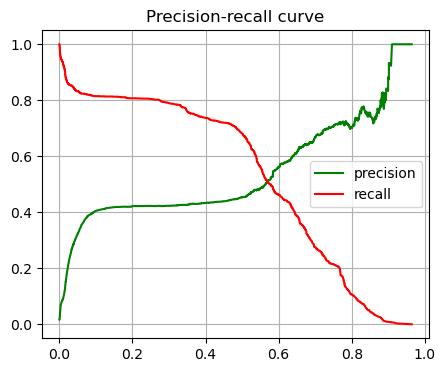

In [160]:
plt.figure(figsize = (5, 4))
plt.grid(True)

plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")

plt.legend(['precision','recall'])
plt.title('Precision-Recall curve')
plt.show()

In [161]:
y_pred_valid_ = pd.DataFrame(y_pred_valid_).rename(columns = {0: 'predict'})

y_pred_all_01_ = y_pred_valid_['predict'].apply(lambda x: 1 if x >= 0.8 else 0)
# y_pred_all_01

In [162]:
confusion = metrics.confusion_matrix(y_valid, y_pred_all_01_)
confusion

array([[90203,    72],
       [ 1418,   170]])

In [163]:
Precision = confusion[1,1]/(confusion[0,1] + confusion[1,1])
Precision

0.7024793388429752

In [523]:
# ******************************************************************************************************************************

[LightGBM] [Info] Number of positive: 11824, number of negative: 677144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.195271 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 688968, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017162 -> initscore=-4.047753
[LightGBM] [Info] Start training from score -4.047753
[LightGBM] [Info] Number of positive: 11847, number of negative: 677121
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.207896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 681
[LightGBM] [Info] Number of data points in the train set: 688968, number of used features: 33
[LightGBM]

#### Hyperopt and k-fold CV for hyperparameters tuning

In [396]:
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    
    'n_estimators': 100,
    'learning_rate': 0.01, 
    
#     'feature_fraction': 0.75,
#     'bagging_fraction': 0.75,
#     'bagging_freq': 1,
    
    'min_gain_to_split': 1e-3,
    'reg_lambda': 1e-1,
   
#     'max_depth': 8,
    'num_leaves': 2**5,
    'min_data_in_leaf': 2**5, 
    
    'is_unbalance': True,
    'importance_type': 'gain',
    
    'nthread': -1,
    'bagging_seed': 42, 
}

In [402]:
from hyperopt import fmin, tpe, hp

alpha = 0.5

space = {
    'n_estimators': hp.choice('n_estimators', list(range(30, 500, 10))),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.001), np.log(0.5)), 
    'max_depth': hp.quniform('max_depth', 3, 10, 1), 
    'colsample_bytree': hp.quniform('colsample_bytree', 0.8, 1, 0.01), 
    'min_child_samples': hp.quniform('min_child_samples', 2, 300, 1), 
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 5),
}

def objective(params):
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'importance_type': 'gain',

        'nthread': -1,
        'bagging_seed': 42, 
        
        'n_estimators': 100,
        'learning_rate': (params['learning_rate']),
        'num_leaves': 2**int(params['max_depth']),
        'max_depth': int(params['max_depth']),
        'colsample_bytree': (params['colsample_bytree']),
        'min_child_samples': int(params['min_child_samples']) ,
        'reg_lambda': params['reg_lambda'],
        'reg_alpha': params['reg_alpha'],
    }
 
    model_lgb = lgb.LGBMClassifier(**lgb_params)

    model_lgb.fit(
        X_train[features_corr_BE_L1_v2],
        y_train, 
        eval_metric = "auc",
        # verbose = -1,
        # early_stopping_rounds = 10,
        eval_set = [(X_train[features_corr_BE_L1_v2], y_train), (X_test[features_corr_BE_L1_v2], y_test)]
    )
 
    forecast_lgb_test = model_lgb.predict_proba(X_test[features_corr_BE_L1_v2])[:,1]
    score_test = roc_auc_score(y_test, forecast_lgb_test)
    
    if alpha > 0:
        forecast_lgb_train = model_lgb.predict_proba(X_train[features_corr_BE_L1_v2])[:,1]
        score_train = roc_auc_score(y_train, forecast_lgb_train)
        
        score_total = score_test - alpha * (score_train - score_test)
        
    else:
        score_total = score_test
    
    print("score {:.5f}; params {}".format(score_test, params))
    return -score_total

best = fmin(
    fn = objective,
    space = space,
    algo = tpe.suggest,
    max_evals = 50
)

[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
[LightGBM] [Warning] min_gain_to_split is set=0.001, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.001
[LightGBM] [Info] Number of positive: 19411, number of negative: 1091159
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923                      
[LightGBM] [Info] Number of data points in the train set: 1110570, number of used features: 29
[LightGBM] [Warning] min_data_in_leaf is set=32,

In [403]:
best

{'colsample_bytree': 0.98,
 'learning_rate': 0.0025143978105942972,
 'max_depth': 4.0,
 'min_child_samples': 238.0,
 'n_estimators': 13,
 'reg_alpha': 3.069193444707498,
 'reg_lambda': 2.542787746173904}

In [404]:
clf_2.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [405]:
from sklearn import model_selection, datasets, linear_model, metrics

kfold = model_selection.KFold(n_splits = 4)

AUC_cv_2 = cross_val_score(clf_2, X_not_target[features_corr_BE_L1_v2], y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
AUC_cv_2

# array([0.96842015, 0.96866814, 0.96902691, 0.9674114 ])

array([0.96842015, 0.96866814, 0.96902691, 0.9674114 ])

In [406]:
model_lgb = lgb.LGBMClassifier(**best)
model_lgb

LGBMClassifier(colsample_bytree=0.98, learning_rate=0.0025143978105942972,
               max_depth=4.0, min_child_samples=238.0, n_estimators=13,
               reg_alpha=3.069193444707498, reg_lambda=2.542787746173904)

In [410]:
model_lgb = lgb.LGBMClassifier(colsample_bytree=0.98, learning_rate=0.0025143978105942972,
               max_depth = 4, min_child_samples = 238, n_estimators = 13,
               reg_alpha=3.069193444707498, reg_lambda=2.542787746173904)

model_lgb.fit(X_train[features_corr_BE_L1_v2], y_train)

[LightGBM] [Info] Number of positive: 19411, number of negative: 1091159
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 923
[LightGBM] [Info] Number of data points in the train set: 1110570, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017478 -> initscore=-4.029156
[LightGBM] [Info] Start training from score -4.029156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(colsample_bytree=0.98, learning_rate=0.0025143978105942972,
               max_depth=4, min_child_samples=238, n_estimators=13,
               reg_alpha=3.069193444707498, reg_lambda=2.542787746173904)

In [413]:
kfold = model_selection.KFold(n_splits = 4)

AUC_cv_2_h = cross_val_score(model_lgb , X_not_target[features_corr_BE_L1_v2], y, cv = kfold, scoring = 'roc_auc', n_jobs = -1)
AUC_cv_2_h

array([0.94795964, 0.94764434, 0.94905094, 0.94697987])

[LightGBM] [Info] Number of positive: 18096, number of negative: 1023063
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.269192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 1041159, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.017381 -> initscore=-4.034865
[LightGBM] [Info] Start training from score -4.034865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [ ]:
# *******************************************************************************************************************

#### Choosing The Number of Clusters

In [ ]:
clustering_score = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random', random_state = 42)
    kmeans.fit(X)
    clustering_score.append(kmeans.inertia_) # inertia_ = Sum of squared distances of samples to their closest cluster center.
    

plt.figure(figsize = (10, 6))
plt.plot(range(1, 11), clustering_score)
plt.scatter(5, clustering_score[4], s = 200, c = 'red', marker = '*')
plt.title('The Elbow Method')
plt.xlabel('No. of Clusters')
plt.ylabel('Clustering Score')
plt.show()